# Forecast Mercadona Actuaciones

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima.model import ARIMA

## Import Dataset

In [2]:
# import dataframe
df = pd.read_excel('time_series_df1.xlsx')
df.head(5)

Date  40822206420389  40822206420391  40824306006327  40824306006328  \
0 2021-03-31              75               8            2064             337   
1 2021-06-30               0               0              25              30   
2 2021-09-30               0               0               0               0   
3 2021-12-31              32               2               0               0   
4 2022-03-31              23               0               0               0   

   40824306006330  40824306006331  40824306006923  40824306006924  \
0              26              15             428             726   
1               0               0              20              97   
2               0               0              19               0   
3               0               0             118              55   
4               0               0             463              40   

   40828820101607  ...  40913703213009  40BDP265I  40BRP775I  40BVP650I  \
0               0  ...               0          0          0          0   
1               0  ...               2          0          3          2   
2               0  ...               0         23          0          0   
3               0  ...               0          0          0          0   
4               0  ...               0          0          0          0   

   40LL500XI  40PT320PI  40RC530BI  40SM530CI  40ST320TI  40ST321TI  
0          0          8          1         11          8          0  
1          1          0          2          6          0         14  
2          0          0          0          0          0          1  
3          0          0          0          0          0          3  
4          0          0          0          0          0          0  

[5 rows x 74 columns]

## Exploratory Analysis

### Correlation

In [3]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Print the correlation matrix
#print(corr_matrix)

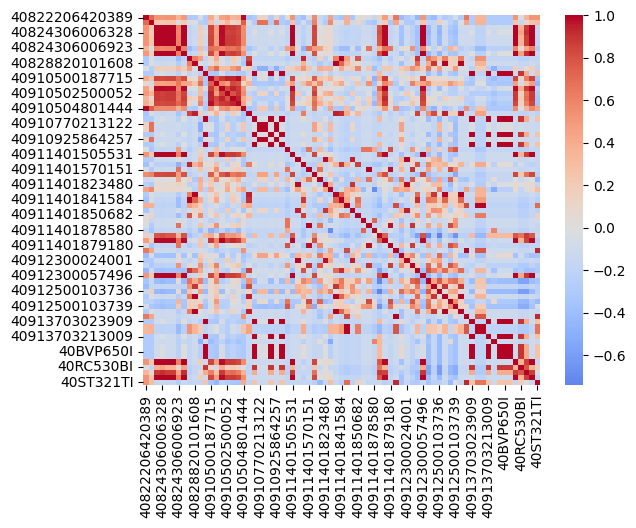

In [4]:
# Create a heatmap of the correlation matrix
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)

# Show the plot
plt.show()

There is clear correlation between some of the materials
--> investigate how this can help the forecasting model

### Time Series

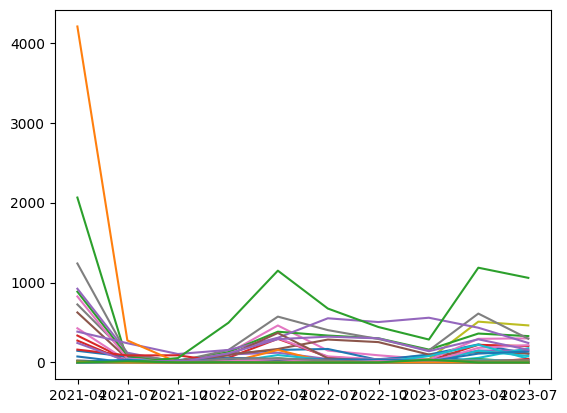

In [5]:
# Convert the date column to a datetime object
df['Date'] = pd.to_datetime(df['Date'])

# Set the date column as the index of the DataFrame
df = df.set_index('Date')

# Plot the time series data
plt.plot(df)

# Set the plot title and axis labels
# plt.title('Your Title')
# plt.xlabel('Date')
# plt.ylabel('Your Y Label')

# Show the plot
plt.show()

Lots of materials, therefore I am going to cluster them in groups based on correlation to analyze them in batches.

## Hierarchical & Agglomerative Cluster

User cluster to group the materials into different batches and create separate DF for each batch to analyze the batches individually.

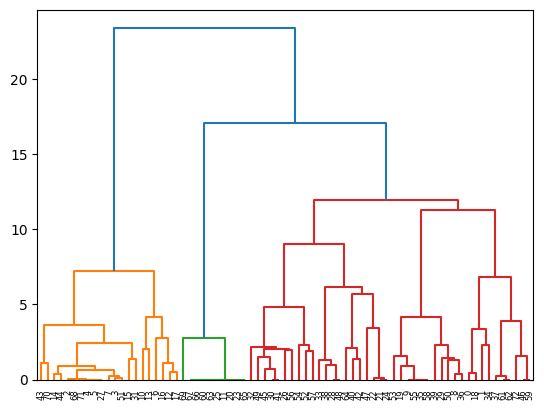

In [6]:
# Convert the correlation matrix to a distance matrix
dist_matrix = (1 - corr_matrix).values
dist_matrix[np.isnan(dist_matrix)] = 0

# Perform hierarchical clustering on the distance matrix
linkage_matrix = hierarchy.linkage(dist_matrix, method='ward')

# Use the dendrogram to determine the optimal number of clusters
plt.figure()
dn = hierarchy.dendrogram(linkage_matrix)
plt.show()

In [7]:
# Set the number of clusters based on the dendrogram
n_clusters = 4

# Perform agglomerative clustering on the correlation matrix
clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='average').fit(dist_matrix)

# Group the materials into different batches based on the cluster labels
batches = []
for i in range(n_clusters):
    batch = df.columns[clustering.labels_ == i].tolist()
    batches.append(batch)

# Create separate DataFrames for each batch
dfs = []
for batch in batches:
    dfs.append(df[batch])

# Print the materials for each batch
for i, batch in enumerate(batches):
    print(f"Batch {i+1}: ")

# Print the first 5 rows of each DataFrame
for i, df_batch in enumerate(dfs):
    print(f"\nDataFrame for Batch {i+1}:")
    print(df_batch.head())

Batch 1: 
Batch 2: 
Batch 3: 
Batch 4: 

DataFrame for Batch 1:
            40828820101607  40828820101608  40828820204250  40910502500046  \
Date                                                                         
2021-03-31               0               0             146             274   
2021-06-30               0               0              72              12   
2021-09-30               0               0              29              17   
2021-12-31               0               0             104              60   
2022-03-31               0               0             157             296   

            40910505100073  40910930031018  40911401555231  40911401555331  \
Date                                                                         
2021-03-31               0               0               0               0   
2021-06-30               0               0               0              37   
2021-09-30               0               0               0               0   

In [8]:
dfs[0].shape[1],dfs[1].shape[1],dfs[2].shape[1],dfs[3].shape[1]

(28, 3, 32, 10)

In [9]:
batch1 = dfs[0]
batch2 = dfs[1]
batch3 = dfs[2]
batch4 = dfs[3]

### Batch 4


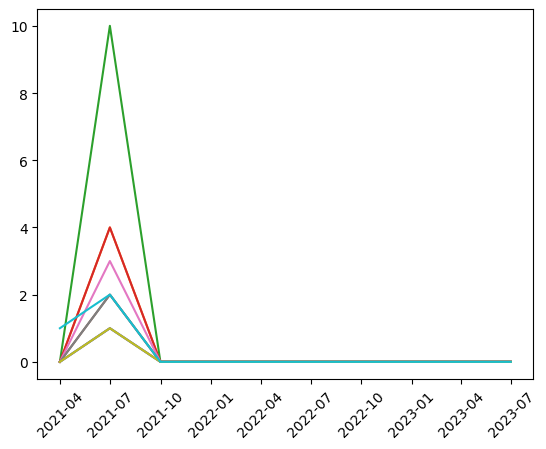

In [10]:
# Time Series analysis
plt.plot(batch4)
plt.xticks(rotation=45)
plt.show()

We are not going to proceed with this batch given the fact that these materials have not been order since Q3 2021.

### Batch 2

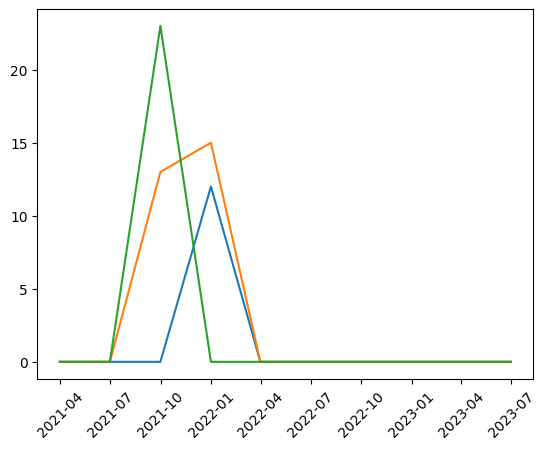

In [11]:
# Time Series analysis
plt.plot(batch2)
plt.xticks(rotation=45)
plt.show()

Unclear if I will proceed with this batch given the fact that these materials have not been order since Q4 2021. We will see further on.

### Batch 3

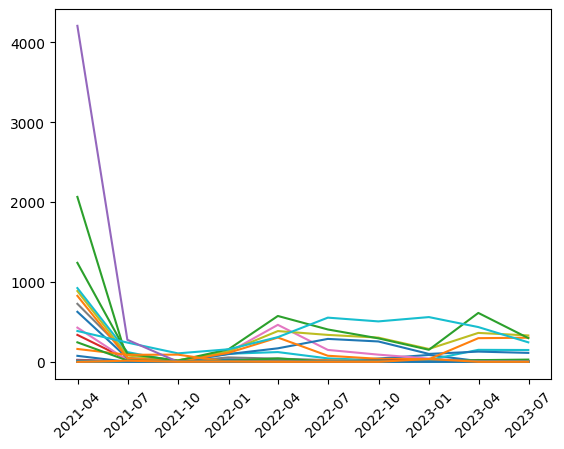

In [12]:
# Time Series analysis
plt.plot(batch3)
plt.xticks(rotation=45)
plt.show()

In [13]:
# Set the date from which you want to check for 0 values
start_date = '2021-12-31'

# Check for 0 values in each material column from the start date forward
for col in batch3.columns:
    if (batch3[col][start_date:] == 0).all():
        print(col, f' has all 0 value from {start_date} forward.')

40824306006327  has all 0 value from 2021-12-31 forward.
40824306006328  has all 0 value from 2021-12-31 forward.
40824306006330  has all 0 value from 2021-12-31 forward.
40824306006331  has all 0 value from 2021-12-31 forward.
40911401505531  has all 0 value from 2021-12-31 forward.
40912300057496  has all 0 value from 2021-12-31 forward.
40PT320PI  has all 0 value from 2021-12-31 forward.
40SM530CI  has all 0 value from 2021-12-31 forward.
40ST320TI  has all 0 value from 2021-12-31 forward.


### Batch 1

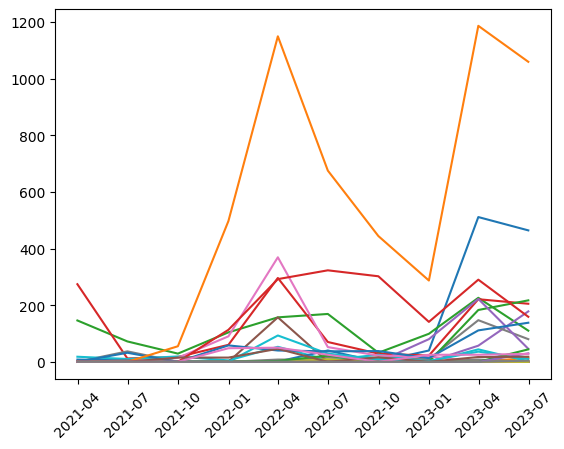

In [14]:
# Time Series analysis
plt.plot(batch1)
plt.xticks(rotation=45)
plt.show()

In [15]:
# Set the date from which you want to check for 0 values
start_date = '2021-12-31'

# Check for 0 values in each material column from the start date forward
for col in batch1.columns:
    if (batch1[col][start_date:] == 0).all():
        print(col, f' has all 0 value from  forward.')

In this batch there are no materials that were not ordered after 2021 so we will forecast values for all of them.



## Analyze Stationarity of times series BATCH 1


We need to make the time series stationary and determine the order of differencing needed.

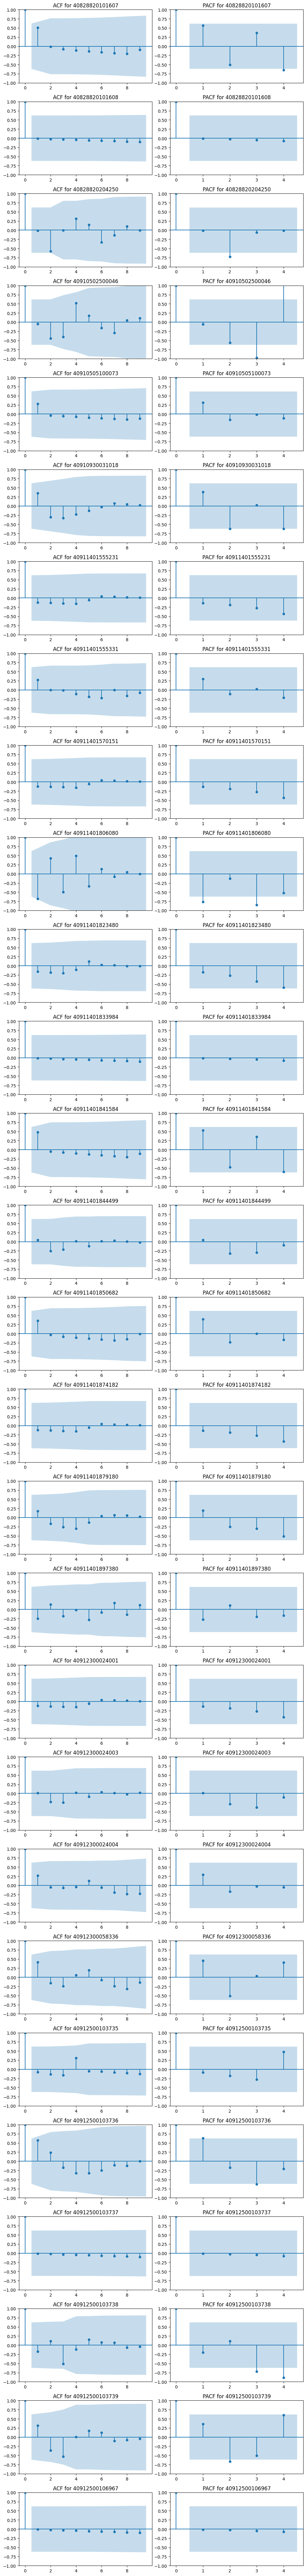

In [16]:
# Create ACF and PACF plots for each material column
fig, axs = plt.subplots(len(batch1.columns), 2, figsize=(10, 84))
for i, col in enumerate(batch1.columns):
    sm.graphics.tsa.plot_acf(batch1[col], ax=axs[i, 0])
    sm.graphics.tsa.plot_pacf(batch1[col], lags=4, ax=axs[i, 1])
    axs[i, 0].set_title(f'ACF for {col}')
    axs[i, 1].set_title(f'PACF for {col}')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [17]:
# Loop through each column except the first (assuming the first column is the date column)
for col in batch1.columns[1:]:
    # Perform the ADF test on the time series after differencing
    #diff = batch1[col].diff().dropna()
    result = adfuller(batch1[col])

    # Print the results of the ADF test
    print(f'Column: {col}')
    print(f'ADF test statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] < 0.05:
        print('Series is stationary')
    else:
        print('Series is non-stationary')
    print('------------------------')

Column: 40828820101608
ADF test statistic: nan
p-value: nan
Series is non-stationary
------------------------
Column: 40828820204250
ADF test statistic: -4.3340503587290895
p-value: 0.0003876175482486093
Series is stationary
------------------------
Column: 40910502500046
ADF test statistic: -11.271206587934367
p-value: 1.5352750803548962e-20
Series is stationary
------------------------
Column: 40910505100073
ADF test statistic: 5.3274853801169595
p-value: 1.0
Series is non-stationary
------------------------
Column: 40910930031018
ADF test statistic: -2.2360679774997902
p-value: 0.19341617825473156
Series is non-stationary
------------------------
Column: 40911401555231
ADF test statistic: -3.0
p-value: 0.034894400275345266
Series is stationary
------------------------
Column: 40911401555331
ADF test statistic: -1.8021045066693206
p-value: 0.37941736617073213
Series is non-stationary
------------------------
Column: 40911401570151
ADF test statistic: -3.0
p-value: 0.03489440027534526

If the p-value is less than a chosen significance level, typically 0.05, then the null hypothesis of non-stationarity is rejected and the time series is considered stationary.

A stationary time series is one whose mean, variance, and autocorrelation structure remain constant over time. In a non-stationary time series, these statistical properties change over time, which makes it difficult to model or forecast the series accurately.

For materials that are not stationary we will need to determine the order of differencing needed to make the time series stationary. If the time series exhibits a trend, you may need to apply first differencing (i.e., d=1). If the time series also exhibits seasonality, you may need to apply seasonal differencing (i.e., D=1). If the ACF and PACF plots show significant autocorrelation at lag 1, you may need to apply first-order autoregression (i.e., p=1).

Materials non-stationary:

- 40910505100073
- 40910930031018
- 40911401555331
- 40911401841584
- 40911401844499
- 40911401879180
- 40912300024003
- 40912300024004
- 40912500103735

Materials with no variance (I will exclude these from the model due to lack of data):

- 40912500106967
- 40912500103737
- 40911401833984
- 40828820101608
- 40911401555231
- 40911401570151
- 40911401874182
- 40912300024001


The rest of materials seem to be stationary and will not need any differencing.


## Analyze seasonality and Trend for non stationary data BATCH 1

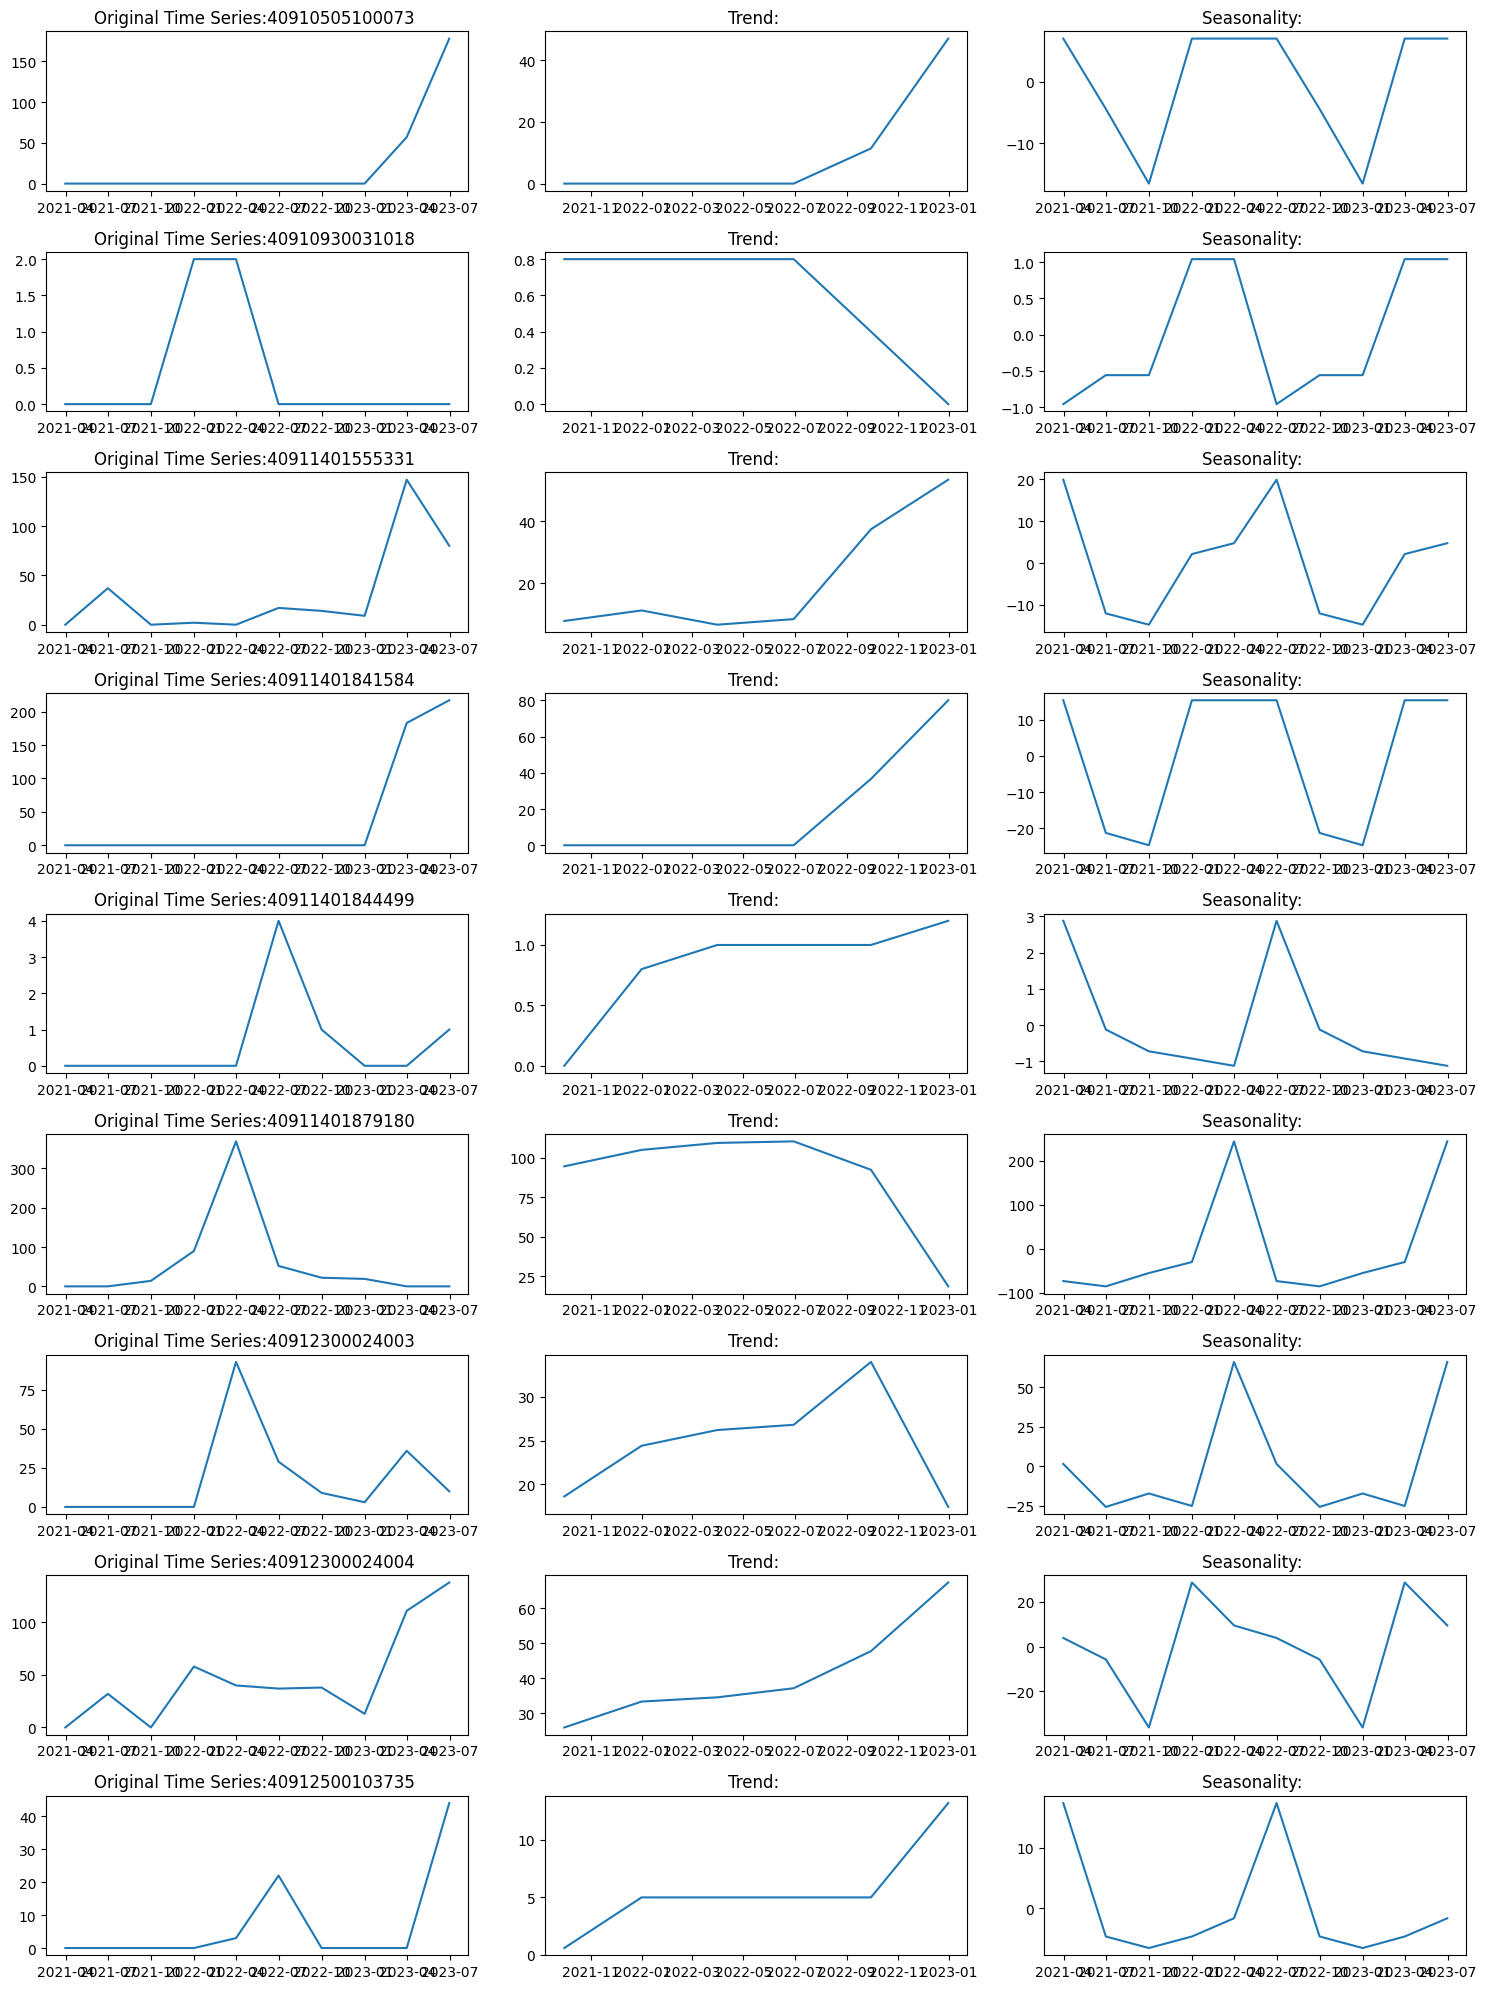

In [18]:
# perform seasonal decomposition on each time series and plot results
materials = ['40910505100073','40910930031018','40911401555331','40911401841584','40911401844499','40911401879180','40912300024003','40912300024004','40912500103735']
fig, axes = plt.subplots(nrows=9, ncols=3, figsize=(15, 20))
for i, col in enumerate(materials):
    decomp = seasonal_decompose(batch1[col], model='additive', period=5)
    axes[i, 0].plot(batch1.index, batch1[col])
    axes[i, 0].set_title(f'Original Time Series:{col} ')
    axes[i, 1].plot(batch1.index, decomp.trend)
    axes[i, 1].set_title(f'Trend: ')
    axes[i, 2].plot(batch1.index, decomp.seasonal)
    axes[i, 2].set_title(f'Seasonality: ')

plt.tight_layout()
plt.show()

## Built model for stationary data BATCH 1

We will first create a separate df for the stationary materials and built models to predict those.

In [19]:
# Create separate dataframes for stationary and non-stationary materials
variance = ['40912500106967', '40912500103737', '40911401833984', '40828820101608', '40911401555231', '40911401570151', '40911401874182', '40912300024001']
exclude_cols =materials + variance
included_cols = batch1.columns.difference(exclude_cols)
stationary_b1 = batch1[included_cols]
non_stationary_b1 = batch1[materials]

In [20]:
# doublbe check for stationarity using ADF test
for col in stationary_b1.columns:
    adf_result = adfuller(stationary_b1[col])
    print(f':Material {col}')
    print(f': ADF Statistic: {adf_result[0]}, p-value: {adf_result[1]}')
    if adf_result[1] < 0.05:
        print('Series is stationary')
    else:
        print('Series is non-stationary')

:Material 40828820101607
: ADF Statistic: -26.813215563975877, p-value: 0.0
Series is stationary
:Material 40828820204250
: ADF Statistic: -4.3340503587290895, p-value: 0.0003876175482486093
Series is stationary
:Material 40910502500046
: ADF Statistic: -11.271206587934367, p-value: 1.5352750803548962e-20
Series is stationary
:Material 40911401806080
: ADF Statistic: -3.118244256347863, p-value: 0.025232163589236703
Series is stationary
:Material 40911401823480
: ADF Statistic: -3.082215949756389, p-value: 0.027897589017709463
Series is stationary
:Material 40911401850682
: ADF Statistic: -6.203484828540981, p-value: 5.73181879599977e-08
Series is stationary
:Material 40911401897380
: ADF Statistic: -4.776411227097635, p-value: 6.032763724066377e-05
Series is stationary
:Material 40912300058336
: ADF Statistic: -3.7970270337586816, p-value: 0.002937879210057298
Series is stationary
:Material 40912500103736
: ADF Statistic: -17.902712303101218, p-value: 2.9492962353397985e-30
Series is 

In [21]:
# SPLIT INTO TRAIN TEST
# Set the date range for the test set
test_start_date = '2022-12-31'
test_end_date = '2023-6-30'

# Split the DataFrame into a training set and a test set based on date
train_df = stationary_b1.loc[stationary_b1.index < test_start_date]
test_df = stationary_b1.loc[(stationary_b1.index >= test_start_date) & (stationary_b1.index <= test_end_date)]

### ARMA MODEL

#### Model Selection based on AIC

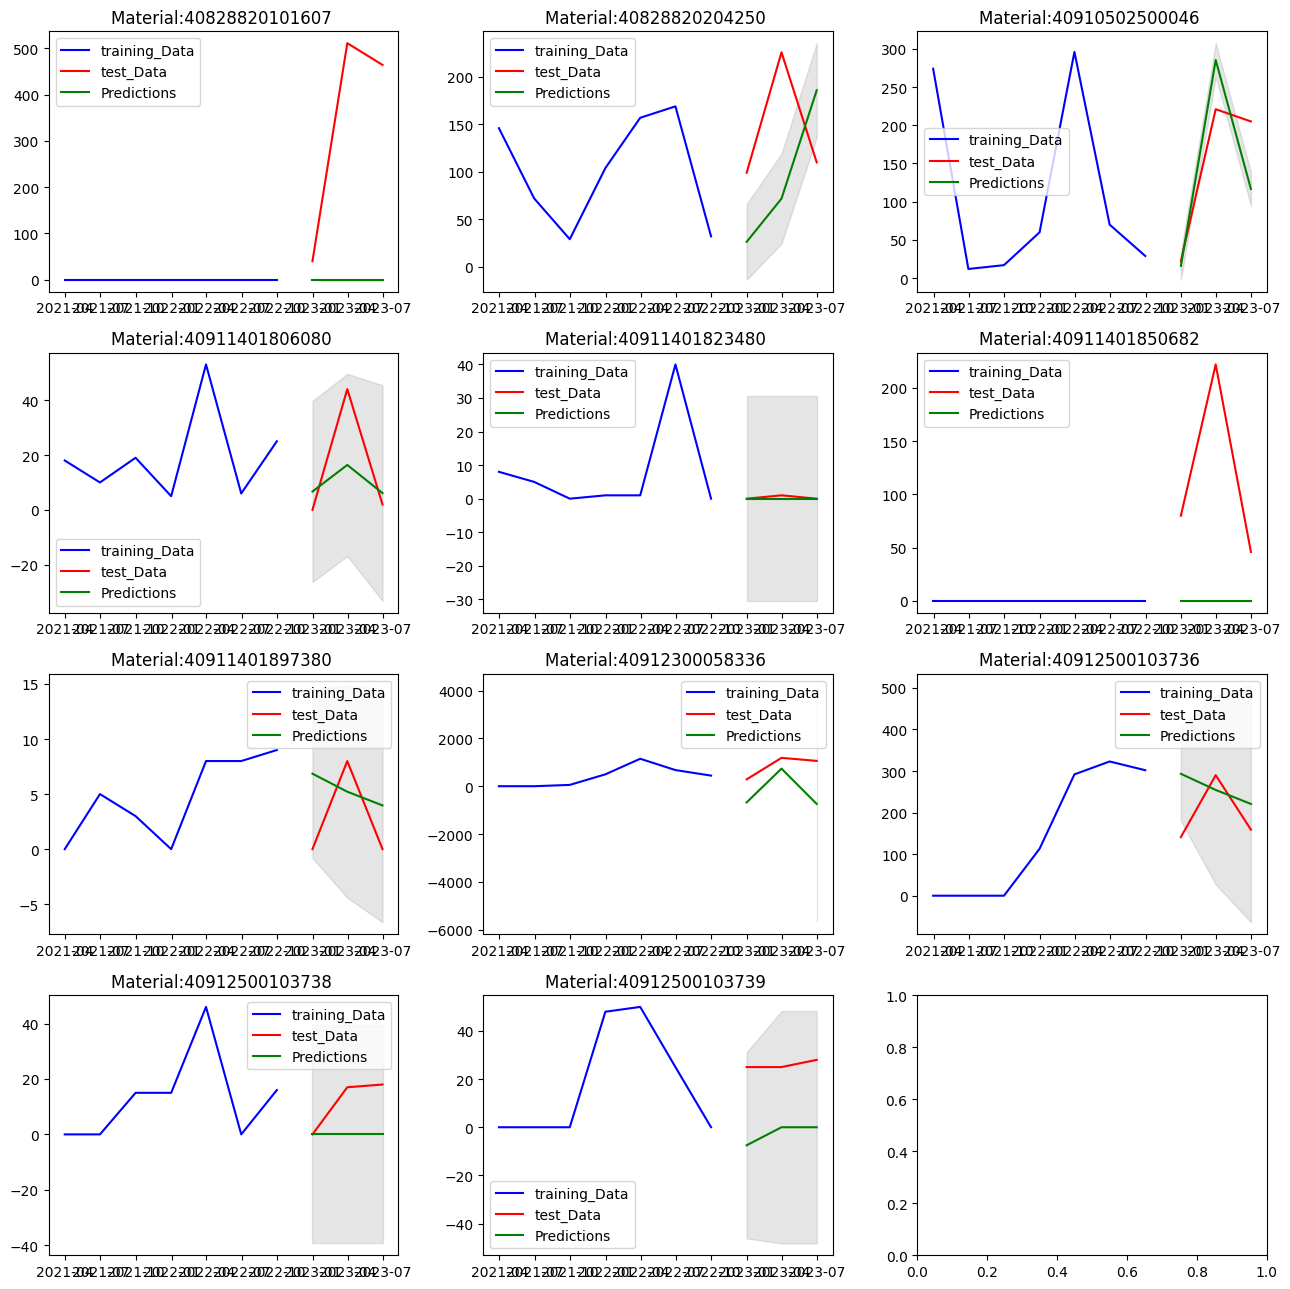

In [22]:
fig, axs = plt.subplots(4, 3, figsize=(13, 13))
axs = axs.flatten()
results = []

for i, col in enumerate(train_df.columns):
    # define input
    y = train_df[col]

    # perform ARIMA model selection
    final_aic = np.inf
    final_order = (0, 0, 0)
    for p in range(5):
        for q in range(5):
              try:
                  current_aic = SARIMAX(y, order=(p, 0, q)).fit().aic
                  if current_aic < final_aic:
                      final_aic = current_aic
                      final_order = (p, 0, q)
              except:
                  pass

    # fit final model
    final_arma = SARIMAX(y, order=final_order).fit()

    # predict future values
    y_pred = final_arma.get_forecast(steps=len(test_df.index))
    y_pred_df = y_pred.conf_int(alpha=0.05)
    y_pred_df['Predictions'] = final_arma.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
    y_pred_df.index = test_df.index

    # plot predictions
    ax = axs[i]
    ax.plot(train_df[col], color='blue', label='training_Data')
    ax.plot(test_df[col], color='red', label='test_Data')
    ax.plot(y_pred_df['Predictions'], color='green', label='Predictions')
    ax.fill_between(y_pred_df.index, y_pred_df.iloc[:, 0], y_pred_df.iloc[:, 1], color='gray', alpha=0.2)
    ax.set_title(f'Material:{col} ')
    ax.legend()
    plt.tight_layout()

    # calculate RMSE and MSE
    rmse = np.sqrt(mean_squared_error(test_df[col], y_pred_df['Predictions']))
    mse = mean_squared_error(test_df[col], y_pred_df['Predictions'])
    aic = final_arma.aic
    bic = final_arma.bic
    results.append([col, rmse, mse, aic, bic])


In [23]:
# create table
results_df = pd.DataFrame(results, columns=['col', 'RMSE', 'MSE', 'AIC', 'BIC'])
print(results_df)

               col         RMSE           MSE         AIC         BIC
0   40828820101607   399.172895  1.593390e+05 -146.315817 -146.369907
1   40828820204250   107.803343  1.162156e+04   83.862819   83.592370
2   40910502500046    63.220316  3.996808e+03   86.201950   85.877411
3   40911401806080    16.580263  2.749051e+02   66.464803   66.302533
4   40911401823480     0.577350  3.333333e-01   60.275296   60.221206
5   40911401850682   138.804419  1.926667e+04 -146.315817 -146.369907
6   40911401897380     4.846390  2.348750e+01   43.818691   43.710511
7   40912300058336  1206.979778  1.456800e+06   99.055556   98.785107
8   40912500103736    97.117256  9.431761e+03   86.351544   86.189274
9   40912500103738    14.294521  2.043333e+02   63.860176   63.806086
10  40912500103739    28.660231  8.214088e+02   66.410899   66.302719


#### Model Selection based on weighted MAE

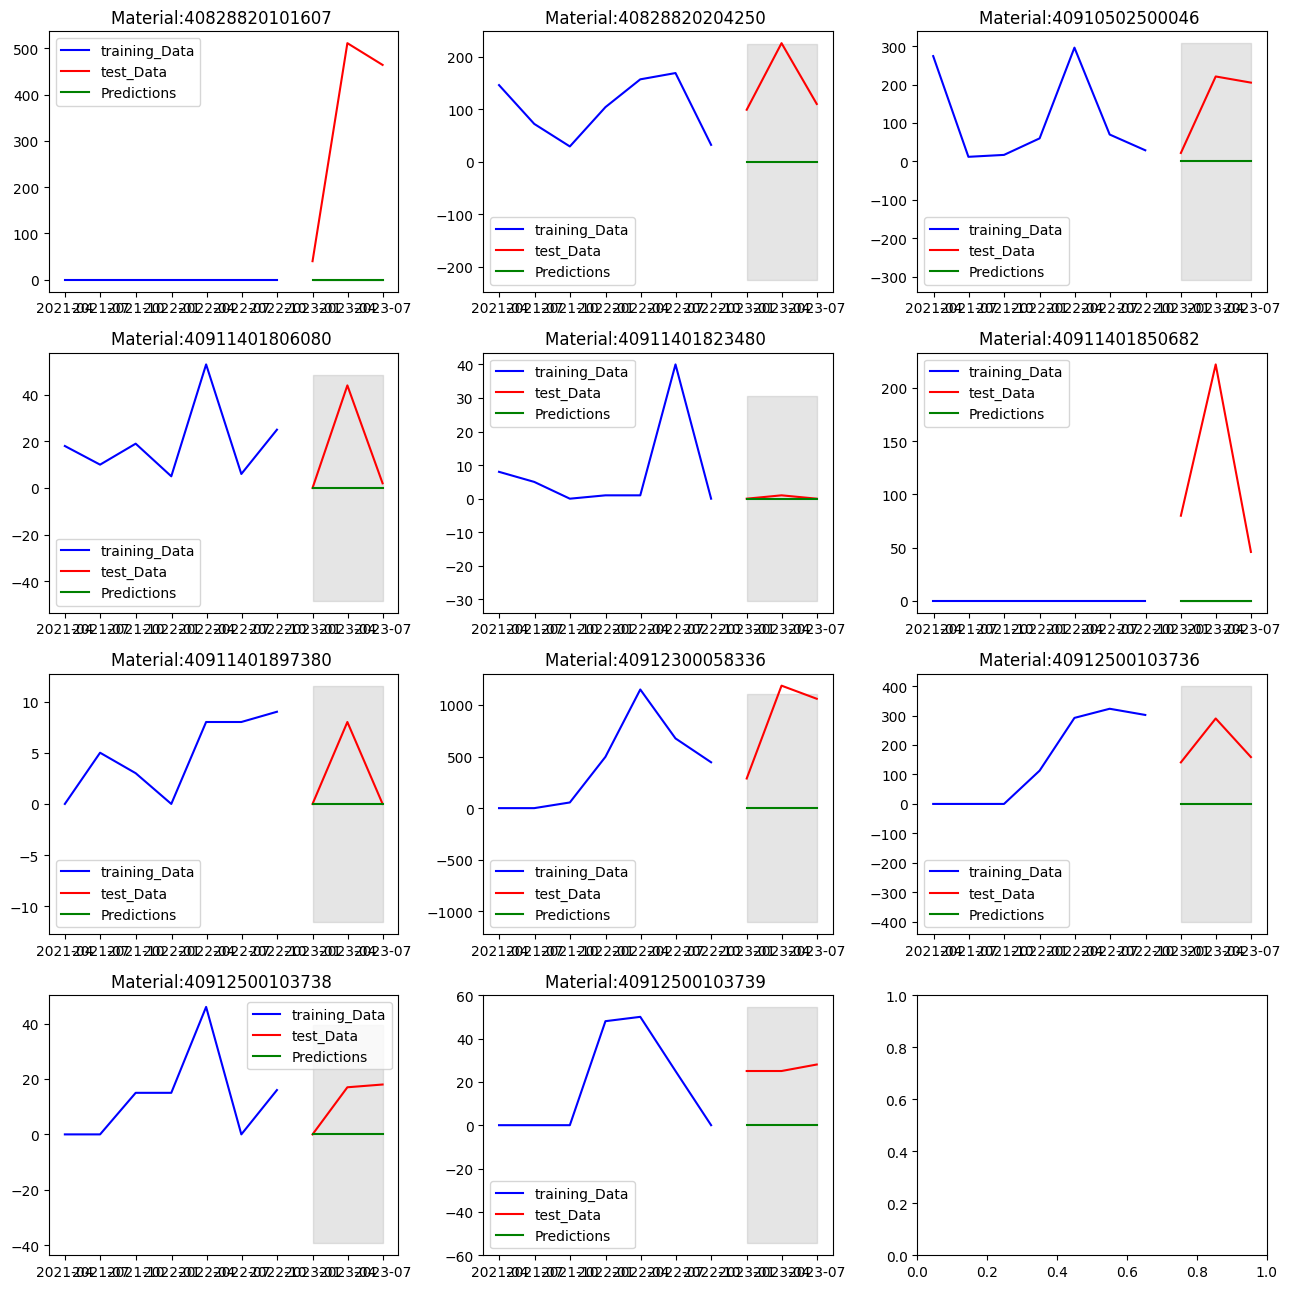

In [24]:
results = []
# Define the weight function for the loss function
def weighted_mae(y_true, y_pred):
    diff = np.abs(y_true - y_pred)
    weight = np.square(diff) / np.mean(np.square(diff))
    return np.mean(weight * diff)

fig, axs = plt.subplots(4, 3, figsize=(13, 13))
axs = axs.flatten()

results = []
for i, col in enumerate(train_df.columns):
    # define input
    y = train_df[col]

    # perform ARIMA model selection based on weighted MAE loss function
    final_aic = np.inf
    final_order = (0, 0, 0)
    for p in range(5):
        for q in range(5):
            try:
                current_model = SARIMAX(y, order=(p, 0, q)).fit()
                current_weighted_mae_loss = weighted_mae(y[-len(test_df):], current_model.forecast(len(test_df)))
                if current_weighted_mae_loss < final_weighted_mae_loss:
                    final_weighted_mae_loss = current_weighted_mae_loss
                    final_order = (p, 0, q)
            except:
                pass

    # fit final model
    final_arma = SARIMAX(y, order=final_order).fit()

    # predict future values
    y_pred = final_arma.get_forecast(steps=len(test_df.index))
    y_pred_df = y_pred.conf_int(alpha=0.05)
    y_pred_df['Predictions'] = final_arma.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
    y_pred_df.index = test_df.index

    # plot predictions
    ax = axs[i]
    ax.plot(train_df[col], color='blue', label='training_Data')
    ax.plot(test_df[col], color='red', label='test_Data')
    ax.plot(y_pred_df['Predictions'], color='green', label='Predictions')
    ax.fill_between(y_pred_df.index, y_pred_df.iloc[:, 0], y_pred_df.iloc[:, 1], color='gray', alpha=0.2)
    ax.set_title(f'Material:{col} ')
    ax.legend()
    plt.tight_layout()

    # calculate RMSE and weighted MAE
    rmse = np.sqrt(mean_squared_error(test_df[col], y_pred_df['Predictions']))
    weighted_mae_loss = weighted_mae(test_df[col], y_pred_df['Predictions'])
    aic = final_arma.aic
    bic = final_arma.bic
    results.append([col, rmse, weighted_mae_loss, aic, bic])

In [25]:
# create table
results_df = pd.DataFrame(results, columns=['col', 'RMSE', 'W_MAE', 'AIC', 'BIC'])
print(results_df)

               col        RMSE        W_MAE         AIC         BIC
0   40828820101607  399.172895   488.254968 -146.315817 -146.369907
1   40828820204250  155.966877   189.710114   88.280262   88.226173
2   40910502500046  174.499284   212.584937   92.649456   92.595366
3   40911401806080   25.429641    43.913402   66.775726   66.721637
4   40911401823480    0.577350     1.000000   60.275296   60.221206
5   40911401850682  138.804419   199.833633 -146.315817 -146.369907
6   40911401897380    4.618802     8.000000   46.695199   46.641109
7   40912300058336  932.817596  1103.072478  110.544333  110.490243
8   40912500103736  207.574886   241.462301   96.372773   96.318683
9   40912500103738   14.294521    17.528548   63.860176   63.806086
10  40912500103739   26.038433    26.156342   68.440340   68.386250


### ARIMA MODEL

#### Model Selection based on weighted MAE

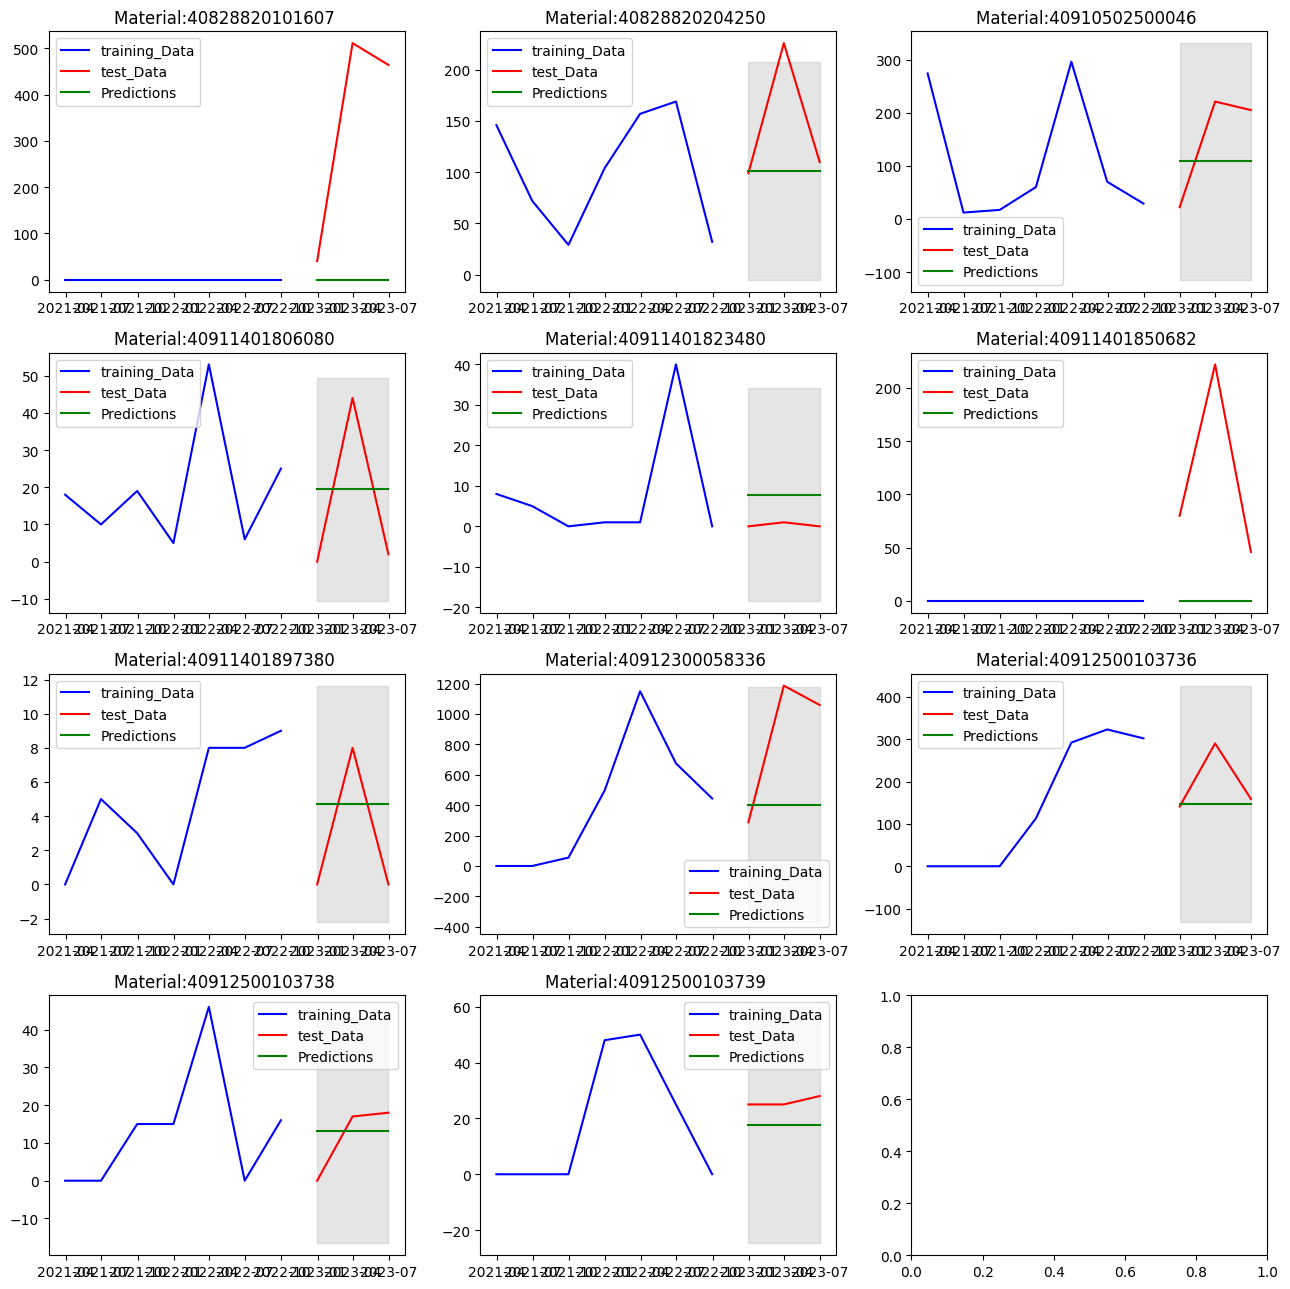

In [26]:

# Define the weight function for the loss function
def weighted_mae(y_true, y_pred):
    diff = np.abs(y_true - y_pred)
    weight = np.square(diff) / np.mean(np.square(diff))
    return np.mean(weight * diff)

fig, axs = plt.subplots(4, 3, figsize=(13, 13))
axs = axs.flatten()

results = []
for i, col in enumerate(train_df.columns):
    # define input
    y = train_df[col]

    # perform ARIMA model selection based on weighted MAE loss function
    final_aic = np.inf
    final_order = (0, 0, 0)
    for p in range(5):
        for q in range(5):
            try:
                current_model = ARIMA(y, order=(p, 0, q)).fit()
                current_weighted_mae_loss = weighted_mae(y[-len(test_df):], current_model.forecast(len(test_df)))
                if current_weighted_mae_loss < final_weighted_mae_loss:
                    final_weighted_mae_loss = current_weighted_mae_loss
                    final_order = (p, 0, q)
            except:
                pass

    # fit final model
    final_arma = sm.tsa.arima.ARIMA(y, order=final_order).fit()

    # predict future values
    y_pred = final_arma.get_forecast(steps=len(test_df.index))
    y_pred_df = y_pred.conf_int(alpha=0.05)
    y_pred_df['Predictions'] = final_arma.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
    y_pred_df.index = test_df.index

    # plot predictions
    ax = axs[i]
    ax.plot(train_df[col], color='blue', label='training_Data')
    ax.plot(test_df[col], color='red', label='test_Data')
    ax.plot(y_pred_df['Predictions'], color='green', label='Predictions')
    ax.fill_between(y_pred_df.index, y_pred_df.iloc[:, 0], y_pred_df.iloc[:, 1], color='gray', alpha=0.2)
    ax.set_title(f'Material:{col} ')
    ax.legend()
    plt.tight_layout()

    # calculate RMSE and weighted MAE
    rmse = np.sqrt(mean_squared_error(test_df[col], y_pred_df['Predictions']))
    weighted_mae_loss = weighted_mae(test_df[col], y_pred_df['Predictions'])
    aic = final_arma.aic
    bic = final_arma.bic
    results.append([col, rmse, weighted_mae_loss, aic, bic])

In [27]:
# create table
results_df = pd.DataFrame(results, columns=['col', 'RMSE', 'W_MAE', 'AIC', 'BIC'])
print(results_df)

               col        RMSE       W_MAE         AIC         BIC
0   40828820101607  399.172899  488.254972 -144.931429 -145.039608
1   40828820204250   72.191453  124.109964   79.768099   79.659919
2   40910502500046   99.168861  100.972413   90.126637   90.018457
3   40911401806080   20.696050   21.372196   62.051166   61.942986
4   40911401823480    7.538558    7.581342   60.209485   60.101306
5   40911401850682  138.804423  199.833636 -144.931429 -145.039608
6   40911401897380    4.291264    4.435111   41.539523   41.431344
7   40912300058336  593.649465  722.955742  107.535902  107.427723
8   40912500103736   82.838178  141.711910   93.289282   93.181103
9   40912500103738    8.390551   11.563222   61.944106   61.835926
10  40912500103739    8.546397    8.917540   66.886691   66.778511


#### Model Selection based on AIC

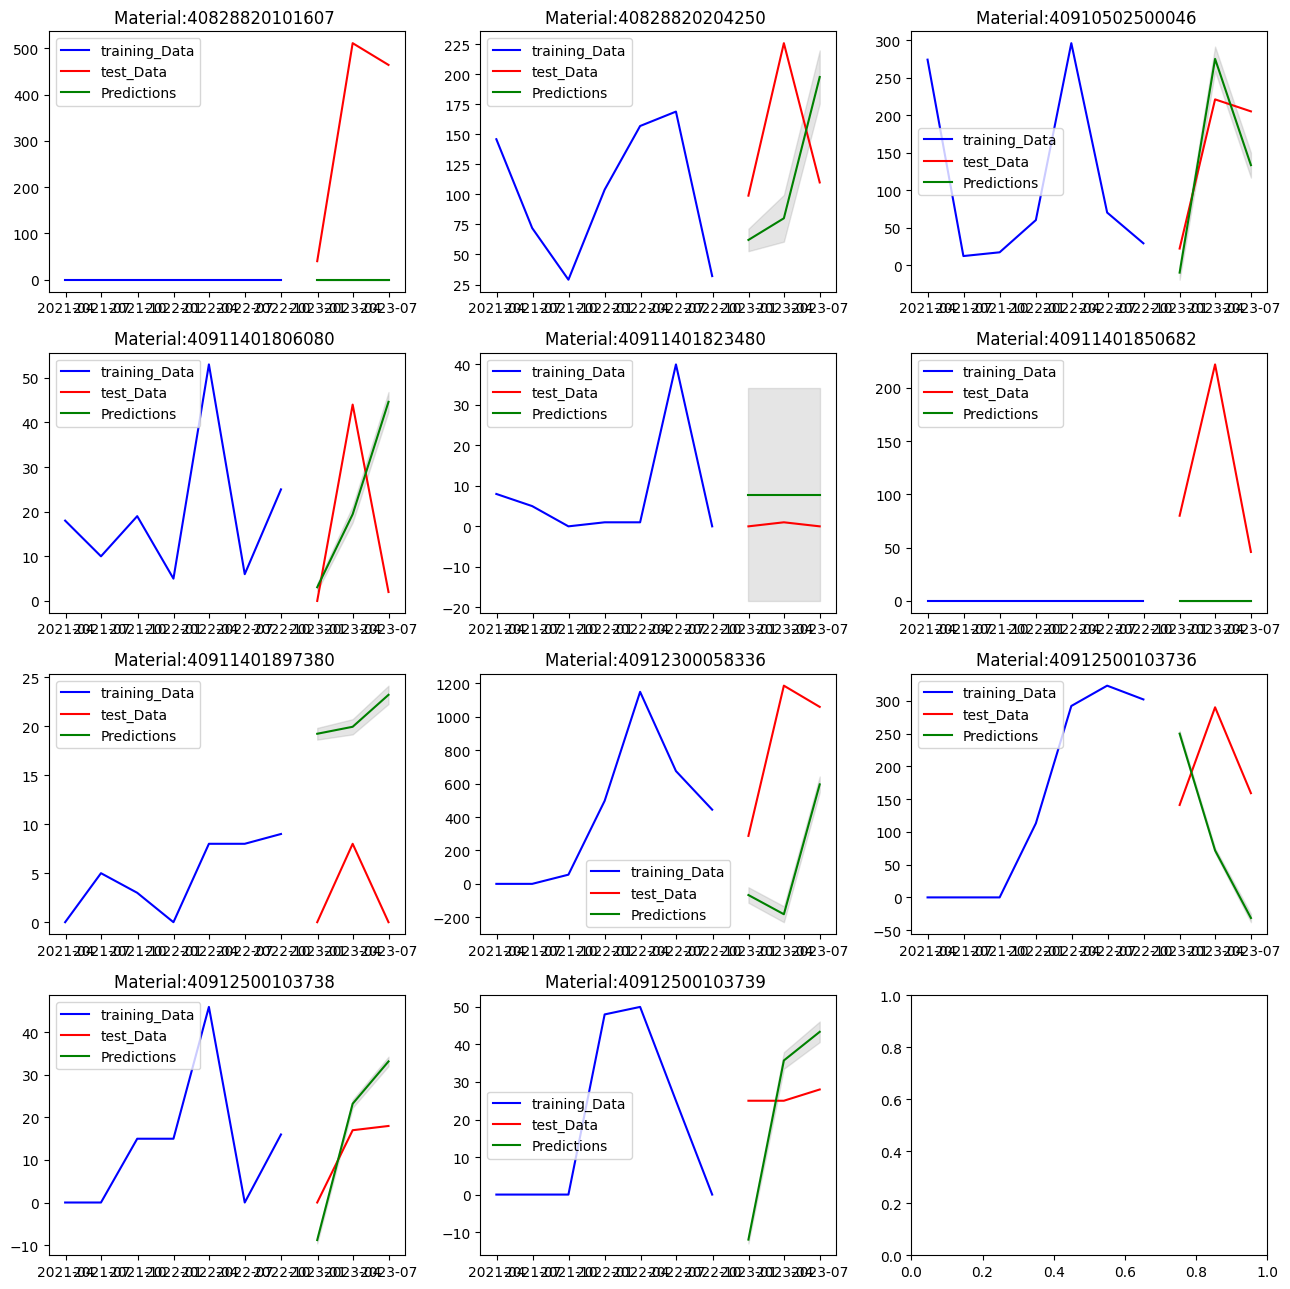

In [28]:
# Define the weight function for the loss function
def weighted_mae(y_true, y_pred):
    diff = np.abs(y_true - y_pred)
    weight = np.square(diff) / np.mean(np.square(diff))
    return np.mean(weight * diff)

fig, axs = plt.subplots(4, 3, figsize=(13, 13))
axs = axs.flatten()

results = []
for i, col in enumerate(train_df.columns):
    # define input
    y = train_df[col]

    # perform ARIMA model selection
    final_aic = np.inf
    final_order = (0, 0, 0)
    for p in range(5):
        for q in range(5):
            try:
                current_aic = ARIMA(y, order=(p, 0, q)).fit().aic
                if current_aic < final_aic:
                    final_aic = current_aic
                    final_order = (p, 0, q)
            except:
                pass

    # fit final model
    final_arma = ARIMA(y, order=final_order).fit()

    # predict future values
    y_pred = final_arma.get_forecast(steps=len(test_df.index))
    y_pred_df = y_pred.conf_int(alpha=0.05)
    y_pred_df['Predictions'] = final_arma.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
    y_pred_df.index = test_df.index

    # plot predictions
    ax = axs[i]
    ax.plot(train_df[col], color='blue', label='training_Data')
    ax.plot(test_df[col], color='red', label='test_Data')
    ax.plot(y_pred_df['Predictions'], color='green', label='Predictions')
    ax.fill_between(y_pred_df.index, y_pred_df.iloc[:, 0], y_pred_df.iloc[:, 1], color='gray', alpha=0.2)
    ax.set_title(f'Material:{col} ')
    ax.legend()
    plt.tight_layout()

    # calculate RMSE and weighted MAE
    rmse = np.sqrt(mean_squared_error(test_df[col], y_pred_df['Predictions']))
    weighted_mae_loss = weighted_mae(test_df[col], y_pred_df['Predictions'])
    aic = final_arma.aic
    bic = final_arma.bic
    results.append([col, rmse, weighted_mae_loss, aic, bic])



In [29]:
# create table
results_df = pd.DataFrame(results, columns=['col', 'RMSE', 'W_MAE', 'AIC', 'BIC'])
print(results_df)

               col        RMSE        W_MAE         AIC         BIC
0   40828820101607  399.172899   488.254972 -144.931429 -145.039608
1   40828820204250  100.570326   126.213950   71.858628   71.479999
2   40910502500046   55.057670    61.549541   72.410829   72.086290
3   40911401806080   28.459643    37.980124   48.730288   48.351659
4   40911401823480    7.538558     7.581342   60.209485   60.101306
5   40911401850682  138.804423   199.833636 -144.931429 -145.039608
6   40911401897380   18.711240    20.272459   39.893651   39.569112
7   40912300058336  858.520389  1222.452345  102.448327  101.961518
8   40912500103736  178.669948   194.225089   76.144124   75.657315
9   40912500103738   10.759329    12.756398   50.570319   50.137600
10  40912500103739   23.944409    32.270284   52.395976   51.963258


## Build model for non-stationary data BATCH 1

In [30]:
# SPLIT INTO TRAIN TEST
# Set the date range for the test set
test_start_date = '2022-12-31'
test_end_date = '2023-6-30'

# Split the DataFrame into a training set and a test set based on date
train_df = non_stationary_b1.loc[non_stationary_b1.index < test_start_date]
test_df = non_stationary_b1.loc[(non_stationary_b1.index >= test_start_date) & (non_stationary_b1.index <= test_end_date)]

### ARIMA


#### Model Selection based on AIC

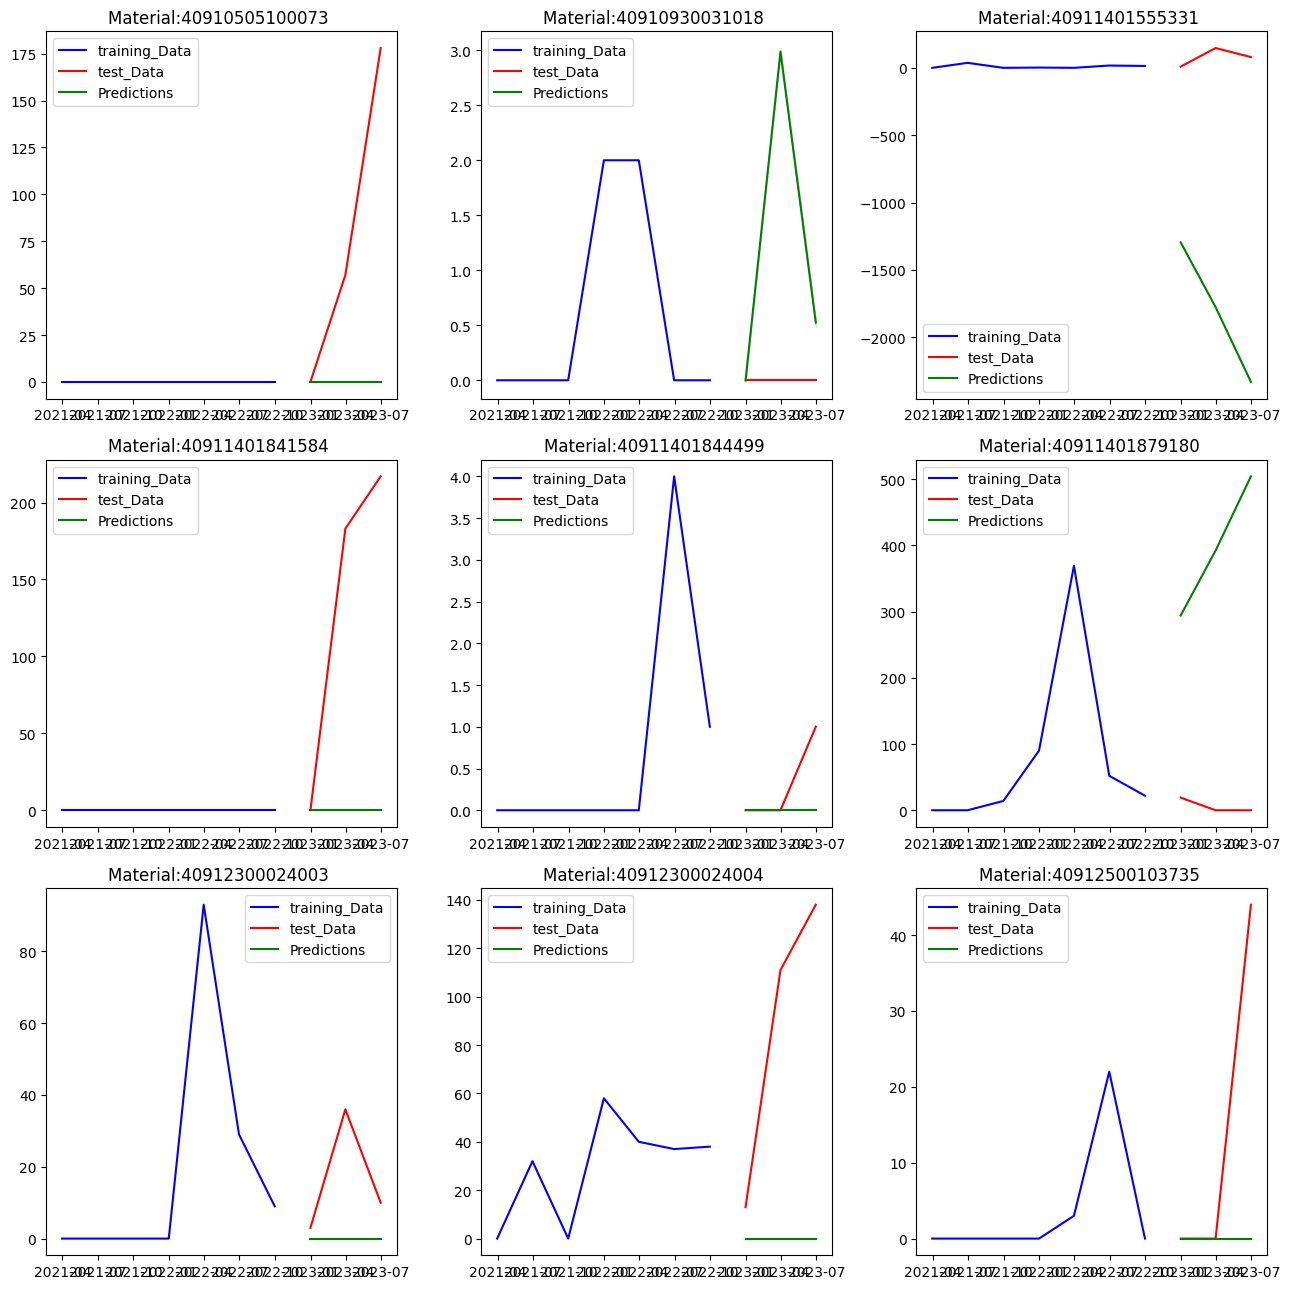

In [31]:
from statsmodels.tsa.arima.model import ARIMA

# Define the weight function for the loss function
def weighted_mae(y_true, y_pred):
    diff = np.abs(y_true - y_pred)
    weight = np.square(diff) / np.mean(np.square(diff))
    return np.mean(weight * diff)

fig, axs = plt.subplots(3, 3, figsize=(13, 13))
axs = axs.flatten()

results = []
for i, col in enumerate(train_df.columns):
    # define input
    y = train_df[col]

    # perform ARIMA model selection
    final_aic = np.inf
    final_order = (0, 0, 0)
    for p in range(5):
        for q in range(5):
          for j in range(5):
            try:
                current_aic = ARIMA(y, order=(p, j, q)).fit().aic
                if current_aic < final_aic:
                    final_aic = current_aic
                    final_order = (p, j, q)
            except:
                pass

    # fit final model
    final_arma = ARIMA(y, order=final_order).fit()

    # predict future values
    y_pred = final_arma.get_forecast(steps=len(test_df.index))
    y_pred_df = y_pred.conf_int(alpha=0.05)
    y_pred_df['Predictions'] = final_arma.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
    y_pred_df.index = test_df.index

    # plot predictions
    ax = axs[i]
    ax.plot(train_df[col], color='blue', label='training_Data')
    ax.plot(test_df[col], color='red', label='test_Data')
    ax.plot(y_pred_df['Predictions'], color='green', label='Predictions')
    ax.fill_between(y_pred_df.index, y_pred_df.iloc[:, 0], y_pred_df.iloc[:, 1], color='gray', alpha=0.2)
    ax.set_title(f'Material:{col} ')
    ax.legend()
    plt.tight_layout()

    # calculate RMSE and weighted MAE
    rmse = np.sqrt(mean_squared_error(test_df[col], y_pred_df['Predictions']))
    weighted_mae_loss = weighted_mae(test_df[col], y_pred_df['Predictions'])
    aic = final_arma.aic
    bic = final_arma.bic
    results.append([col, rmse, weighted_mae_loss, aic, bic])

In [32]:
# create table
results_df = pd.DataFrame(results, columns=['col', 'RMSE', 'W_MAE', 'AIC', 'BIC'])
print(results_df)

              col         RMSE        W_MAE         AIC         BIC
0  40910505100073   107.908916   166.746204 -144.931429 -145.039608
1  40910930031018     1.751474     2.914414    4.991763    4.613134
2  40911401555331  1933.155107  2082.138847    6.000000    4.158883
3  40911401841584   163.888177   202.869274 -144.931429 -145.039608
4  40911401844499     0.577350     1.000000  -11.793509  -13.042952
5  40911401879180   401.374721   432.557551    6.000000    4.158883
6  40912300024003    21.641010    33.938078    6.000000    4.158883
7  40912300024004   102.524794   126.780618   10.000000    5.493061
8  40912500103735    25.403412    44.000000    6.000000    4.158883


#### Model Selection based on MAE

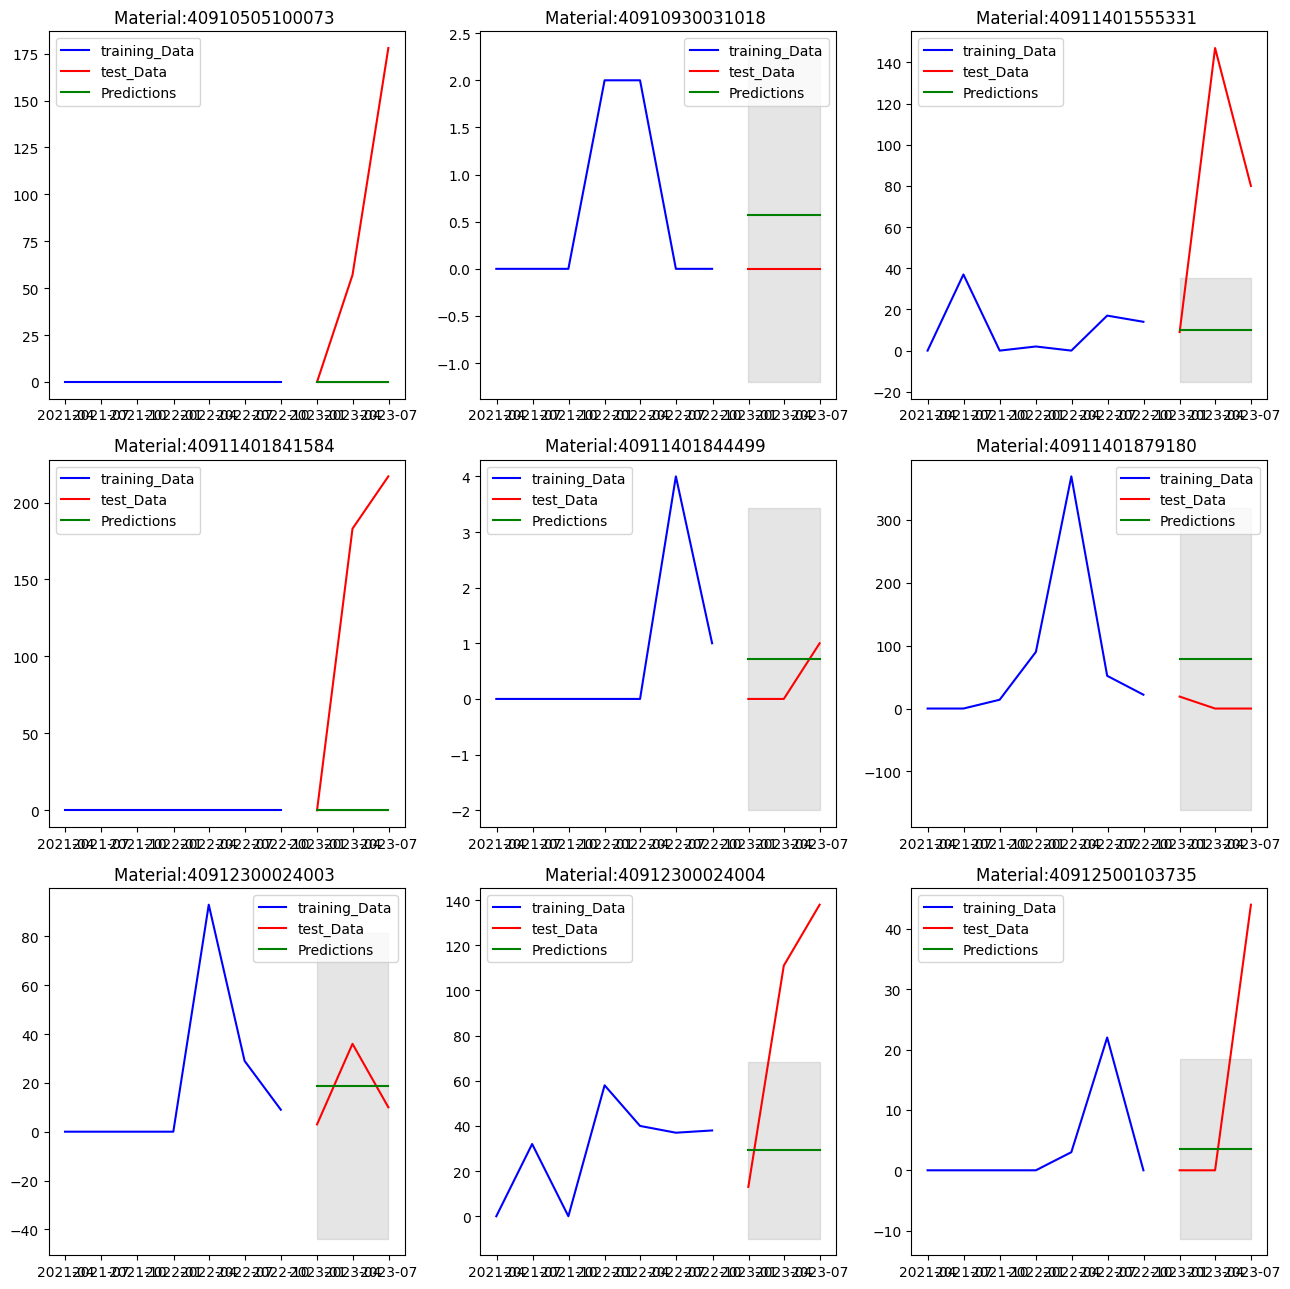

In [33]:
from statsmodels.tsa.api import arima
from statsmodels.tsa.arima.model import ARIMA

results = []
# Define the weight function for the loss function
def weighted_mae(y_true, y_pred):
    diff = np.abs(y_true - y_pred)
    weight = np.square(diff) / np.mean(np.square(diff))
    return np.mean(weight * diff)

fig, axs = plt.subplots(3, 3, figsize=(13, 13))
axs = axs.flatten()

results = []
for i, col in enumerate(train_df.columns):
    # define input
    y = train_df[col]

    # perform ARIMA model selection based on weighted MAE loss function
    final_aic = np.inf
    final_order = (0, 0, 0)
    for p in range(5):
        for q in range(5):
          for j in range(5):
            try:
                current_model = ARIMA(y, order=(p, j, q)).fit()
                current_weighted_mae_loss = weighted_mae(y[-len(test_df):], current_model.forecast(len(test_df)))
                if current_weighted_mae_loss < final_weighted_mae_loss:
                    final_weighted_mae_loss = current_weighted_mae_loss
                    final_order = (p, j, q)
            except:
                pass

    # fit final model
    final_arma = ARIMA(y, order=final_order).fit()

    # predict future values
    y_pred = final_arma.get_forecast(steps=len(test_df.index))
    y_pred_df = y_pred.conf_int(alpha=0.05)
    y_pred_df['Predictions'] = final_arma.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
    y_pred_df.index = test_df.index

    # plot predictions
    ax = axs[i]
    ax.plot(train_df[col], color='blue', label='training_Data')
    ax.plot(test_df[col], color='red', label='test_Data')
    ax.plot(y_pred_df['Predictions'], color='green', label='Predictions')
    ax.fill_between(y_pred_df.index, y_pred_df.iloc[:, 0], y_pred_df.iloc[:, 1], color='gray', alpha=0.2)
    ax.set_title(f'Material:{col} ')
    ax.legend()
    plt.tight_layout()

    # calculate RMSE and weighted MAE
    rmse = np.sqrt(mean_squared_error(test_df[col], y_pred_df['Predictions']))
    weighted_mae_loss = weighted_mae(test_df[col], y_pred_df['Predictions'])
    aic = final_arma.aic
    bic = final_arma.bic
    results.append([col, rmse, weighted_mae_loss, aic, bic])

In [34]:
# create table
results_df = pd.DataFrame(results, columns=['col', 'RMSE', 'W_MAE', 'AIC', 'BIC'])
print(results_df)

              col        RMSE       W_MAE         AIC         BIC
0  40910505100073  107.908916  166.746204 -144.931429 -145.039608
1  40910930031018    0.571425    0.571425   22.444554   22.336374
2  40911401555331   88.825676  123.124381   59.624916   59.516736
3  40911401841584  163.888177  202.869274 -144.931429 -145.039608
4  40911401844499    0.606088    0.682534   28.425461   28.317281
5  40911401879180   72.365940   73.912579   91.169170   91.060990
6  40912300024003   14.395293   15.614500   72.337848   72.229668
7  40912300024004   79.080648   97.798204   65.798960   65.690780
8  40912500103735   23.522896   39.862165   52.248720   52.140541


### SEASONAL ARIMA

#### Model Selection based on MAE

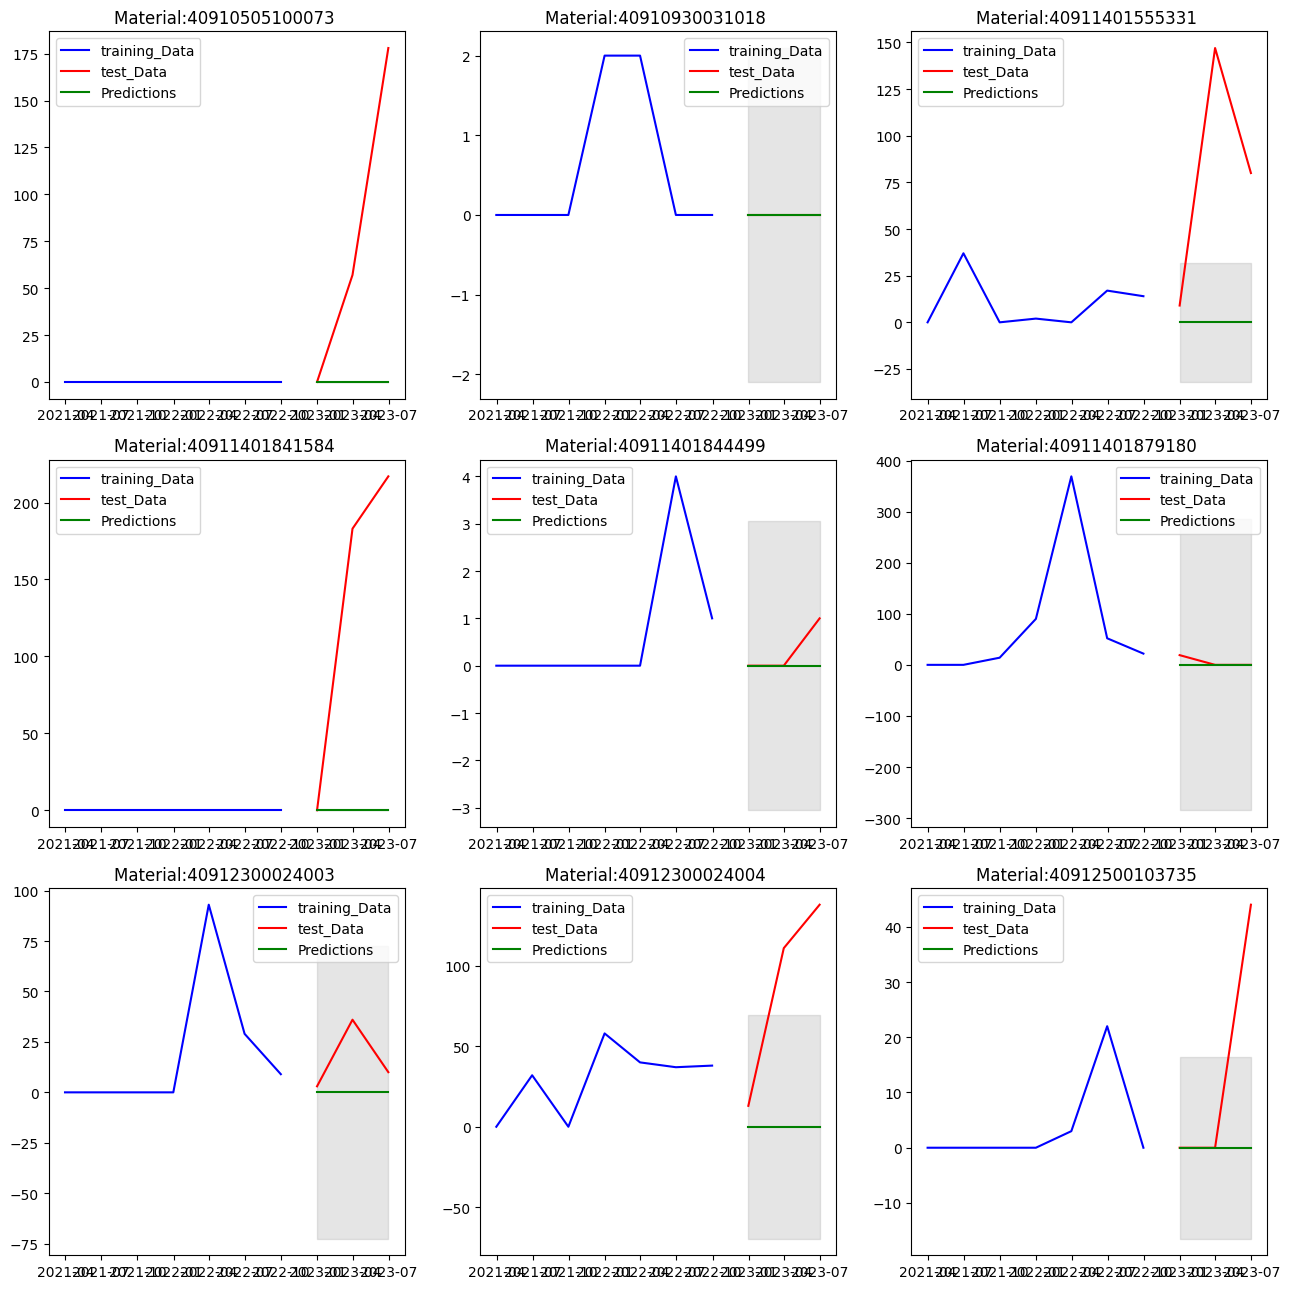

In [35]:
results = []
# Define the weight function for the loss function
def weighted_mae(y_true, y_pred):
    diff = np.abs(y_true - y_pred)
    weight = np.square(diff) / np.mean(np.square(diff))
    return np.mean(weight * diff)

fig, axs = plt.subplots(3, 3, figsize=(13, 13))
axs = axs.flatten()

results = []
for i, col in enumerate(train_df.columns):
    # define input
    y = train_df[col]

    # perform ARIMA model selection based on weighted MAE loss function
    final_aic = np.inf
    final_order = (0, 0, 0)
    for p in range(5):
        for q in range(5):
          for j in range(5):
            try:
                current_model = SARIMAX(y, order = (p,q,j), seasonal_order=(1,1,1,4)).fit()
                current_weighted_mae_loss = weighted_mae(y[-len(test_df):], current_model.forecast(len(test_df)))
                if current_weighted_mae_loss < final_weighted_mae_loss:
                    final_weighted_mae_loss = current_weighted_mae_loss
                    final_order = (p, j, q)
            except:
                pass

    # perform seasonal ARIMA model selection based o weigthed MAE loss function
    final_Sorder = (0, 0, 0, 4)
    for l in range(5):
        for m in range(5):
          for n in range(5):
            try:
                current_model = SARIMAX(y, order = final_order, seasonal_order=(l,m,n,4)).fit()
                current_weighted_mae_loss = weighted_mae(y[-len(test_df):], current_model.forecast(len(test_df)))
                if current_weighted_mae_loss < final_weighted_mae_loss:
                    final_weighted_mae_loss = current_weighted_mae_loss
                    final_Sorder = (l, m, n,4)
            except:
                pass

    # fit final model
        final_arma = SARIMAX(y, order = final_order, seasonal_order=final_Sorder).fit()

    # predict future values
    y_pred = final_arma.get_forecast(steps=len(test_df.index))
    y_pred_df = y_pred.conf_int(alpha=0.05)
    y_pred_df['Predictions'] = final_arma.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
    y_pred_df.index = test_df.index

    # plot predictions
    ax = axs[i]
    ax.plot(train_df[col], color='blue', label='training_Data')
    ax.plot(test_df[col], color='red', label='test_Data')
    ax.plot(y_pred_df['Predictions'], color='green', label='Predictions')
    ax.fill_between(y_pred_df.index, y_pred_df.iloc[:, 0], y_pred_df.iloc[:, 1], color='gray', alpha=0.2)
    ax.set_title(f'Material:{col} ')
    ax.legend()
    plt.tight_layout()

    # calculate RMSE and weighted MAE
    rmse = np.sqrt(mean_squared_error(test_df[col], y_pred_df['Predictions']))
    weighted_mae_loss = weighted_mae(test_df[col], y_pred_df['Predictions'])
    aic = final_arma.aic
    bic = final_arma.bic
    results.append([col, rmse, weighted_mae_loss, aic, bic])

In [36]:
# create table
results_df = pd.DataFrame(results, columns=['col', 'RMSE', 'W_MAE', 'AIC', 'BIC'])
print(results_df)

              col        RMSE       W_MAE         AIC         BIC
0  40910505100073  107.908912  166.746200 -146.315817 -146.369907
1  40910930031018    0.000000         NaN   22.799859   22.745769
2  40911401555331   96.764318  131.336846   60.934560   60.880470
3  40911401841584  163.888173  202.869270 -146.315817 -146.369907
4  40911401844499    0.577350    1.000000   28.076262   28.022172
5  40911401879180   10.969655   19.000000   91.561731   91.507641
6  40912300024003   21.641010   33.938078   72.409219   72.355129
7  40912300024004  102.524794  126.780618   71.822113   71.768023
8  40912500103735   25.403412   44.000000   51.647333   51.593243


#### Model Selection based on AIC

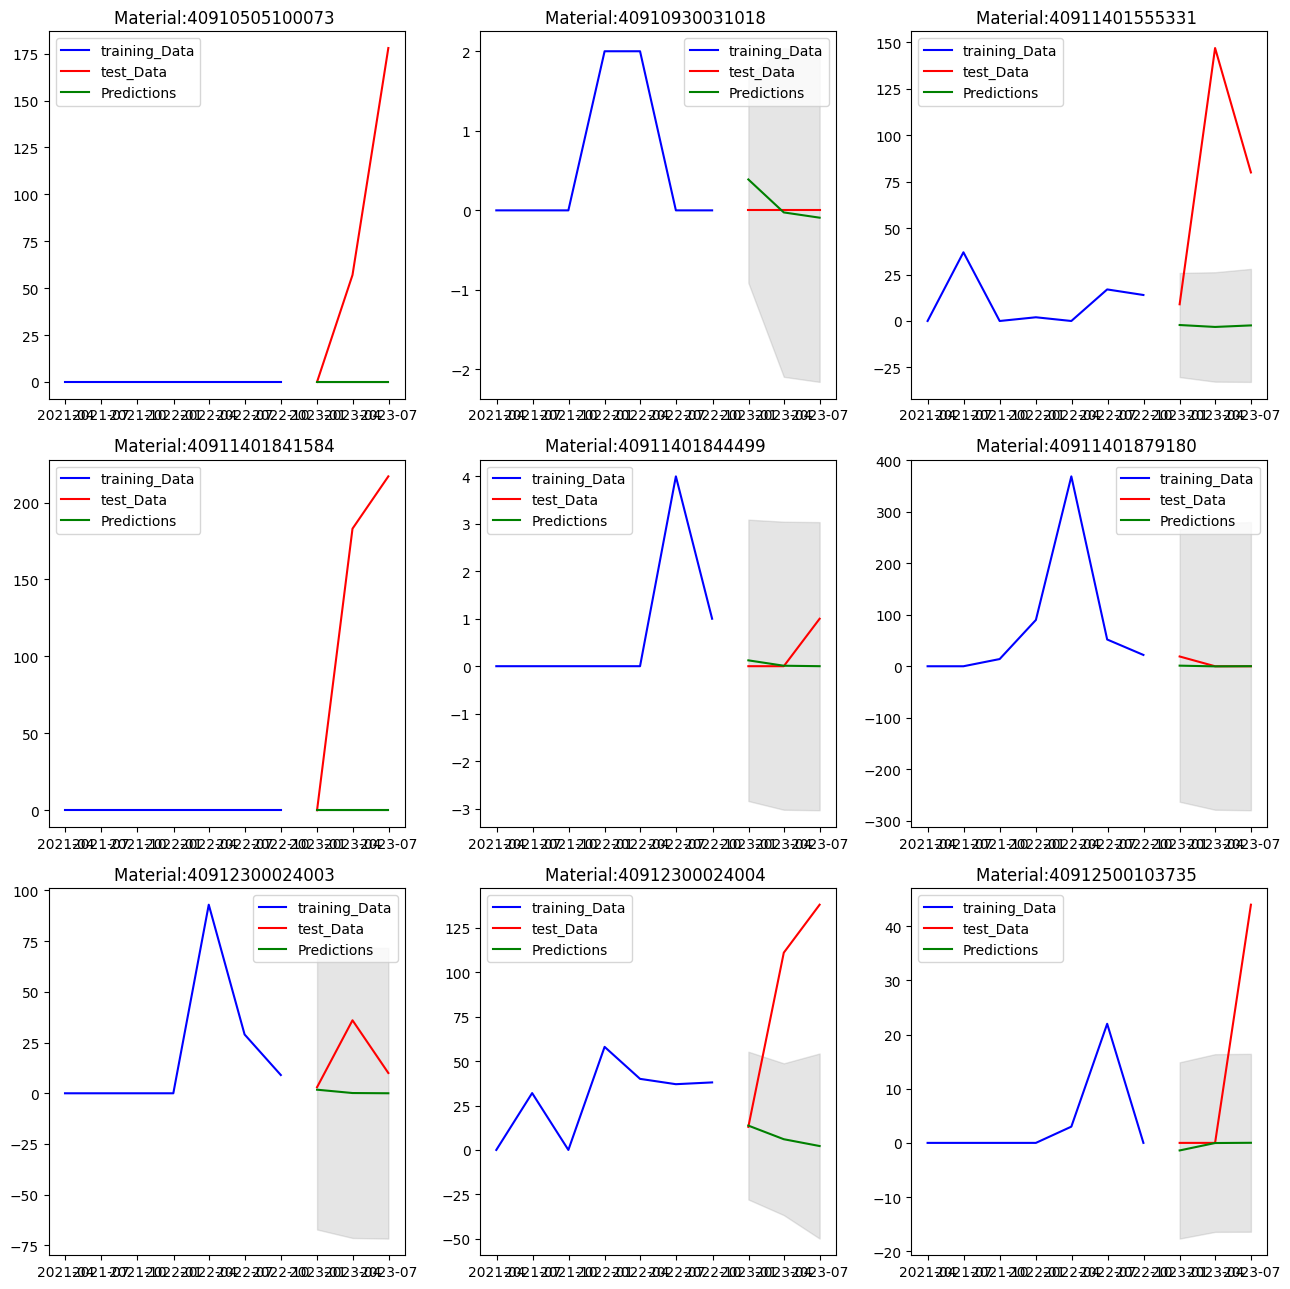

In [37]:
results = []
# Define the weight function for the loss function
def weighted_mae(y_true, y_pred):
    diff = np.abs(y_true - y_pred)
    weight = np.square(diff) / np.mean(np.square(diff))
    return np.mean(weight * diff)

fig, axs = plt.subplots(3, 3, figsize=(13, 13))
axs = axs.flatten()

results = []
for i, col in enumerate(train_df.columns):
    # define input
    y = train_df[col]

    # perform ARIMA model selection based on weighted MAE loss function
    final_aic = np.inf
    final_order = (0, 0, 0)
    for p in range(5):
        for q in range(5):
          for j in range(5):
            try:
                current_aic = SARIMAX(y, order = (p,q,j), seasonal_order=(1,1,1,4)).fit().aic
                if current_aic < final_aic:
                    final_aic = current_aic
                    final_order = (p, j, q)
            except:
                pass

    # perform seasonal ARIMA model selection based o weigthed MAE loss function
    final_Sorder = (0, 0, 0, 4)
    for l in range(5):
        for m in range(5):
          for n in range(5):
            try:
                current_aic = SARIMAX(y, order = final_order, seasonal_order=(l,m,n,4)).fit().aic
                if current_aic < final_aic:
                    final_aic = current_aic
                    final_Sorder = (l, m, n,4)
            except:
                pass

    # fit final model
        final_arma = SARIMAX(y, order = final_order, seasonal_order=final_Sorder).fit()

    # predict future values
    y_pred = final_arma.get_forecast(steps=len(test_df.index))
    y_pred_df = y_pred.conf_int(alpha=0.05)
    y_pred_df['Predictions'] = final_arma.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
    y_pred_df.index = test_df.index

    # plot predictions
    ax = axs[i]
    ax.plot(train_df[col], color='blue', label='training_Data')
    ax.plot(test_df[col], color='red', label='test_Data')
    ax.plot(y_pred_df['Predictions'], color='green', label='Predictions')
    ax.fill_between(y_pred_df.index, y_pred_df.iloc[:, 0], y_pred_df.iloc[:, 1], color='gray', alpha=0.2)
    ax.set_title(f'Material:{col} ')
    ax.legend()
    plt.tight_layout()

    # calculate RMSE and weighted MAE
    rmse = np.sqrt(mean_squared_error(test_df[col], y_pred_df['Predictions']))
    weighted_mae_loss = weighted_mae(test_df[col], y_pred_df['Predictions'])
    aic = final_arma.aic
    bic = final_arma.bic
    results.append([col, rmse, weighted_mae_loss, aic, bic])

In [38]:
# create table
results_df = pd.DataFrame(results, columns=['col', 'RMSE', 'W_MAE', 'AIC', 'BIC'])
print(results_df)

              col        RMSE       W_MAE         AIC         BIC
0  40910505100073  107.908912  166.746200 -146.315817 -146.369907
1  40910930031018    0.231038    0.371344   24.846833   24.630473
2  40911401555331   99.117321  134.001433   66.311034   66.094675
3  40911401841584  163.888173  202.869270 -146.315817 -146.369907
4  40911401844499    0.581622    0.986579   33.706574   33.490214
5  40911401879180   10.293918   17.824069   96.648638   96.432278
6  40912300024003   21.512301   33.978681   77.788970   77.572610
7  40912300024004   99.095783  124.265802   71.933576   71.717217
8  40912500103735   25.405723   43.939112   57.528472   57.312112


## Built Final Models


The models for stationary and non stationary data for BATCH 3 were built in another notebook and the final selection of the model for each material was done.

ARIMA Model based on the best AIC:
- 40828820204250
- 40910502500046
- 40912500103738
- 40910502500076
- 40ST321TI
- 40911401844499


ARIMA model based on the best MAE:
- 40912300024003
- 40912300024004
- 40912500103735
- 40822206420391
- 40910500187715
- 40910502500049
- 40910504801444
- 40911401823880
- 40911401555331
- 40910502500070
- 40912500103739
- 40912300058336
- 40911401897380
- 40911401823480
- 40911401806080


ARMA model based on the best AIC:
- 40912500103736

ARMA model based on the best MAE:
- 40910770213122
- 40910925864214
- 40910925864257
- 40911401631705
- 40911401878980
- 40824306006923
- 40824306006924
- 40910502500052

Seasonal ARIMA based on the best MAE:
- 40910930031018
- 40911401879180

Seasonal ARIMA based on the best AIC:
- 40911401879080




In [39]:
ARIMA_A = ['40828820204250','40910502500046','40912500103738','40910502500076','40ST321TI','40911401844499']
ARIMA_M = ['40912300024003','40912300024004','40912500103735','40822206420391','40910500187715','40910502500049','40910504801444','40911401823880','40911401555331','40910502500070','40912500103739','40912300058336','40911401897380','40911401823480','40911401806080']
ARMA_A = ['40912500103736']
ARMA_M = ['40910770213122','40910925864214','40910925864257','40911401631705','40911401878980','40824306006923','40824306006924','40910502500052']
SARIMA_M = ['40910930031018','40911401879180']
SARIMA_A = ['40911401879080']

In [40]:
df_ARIMA_A = df[ARIMA_A]
df_ARIMA_M = df[ARIMA_M]
df_ARMA_A = df[ARMA_A]
df_ARMA_M = df[ARMA_M]
df_SARIMA_M = df[SARIMA_M]
df_SARIMA_A = df[SARIMA_A]

### ARIMA MODEL BASED ON THE BEST AIC

In [41]:
# SPLIT INTO TRAIN TEST
# Set the date range for the test set
test_start_date = '2022-12-31'
test_end_date = '2023-6-30'

# Split the DataFrame into a training set and a test set based on date
train_df = df_ARIMA_A.loc[df_ARIMA_A.index < test_start_date]
test_df = df_ARIMA_A.loc[(df_ARIMA_A.index >= test_start_date) & (df_ARIMA_A.index <= test_end_date)]

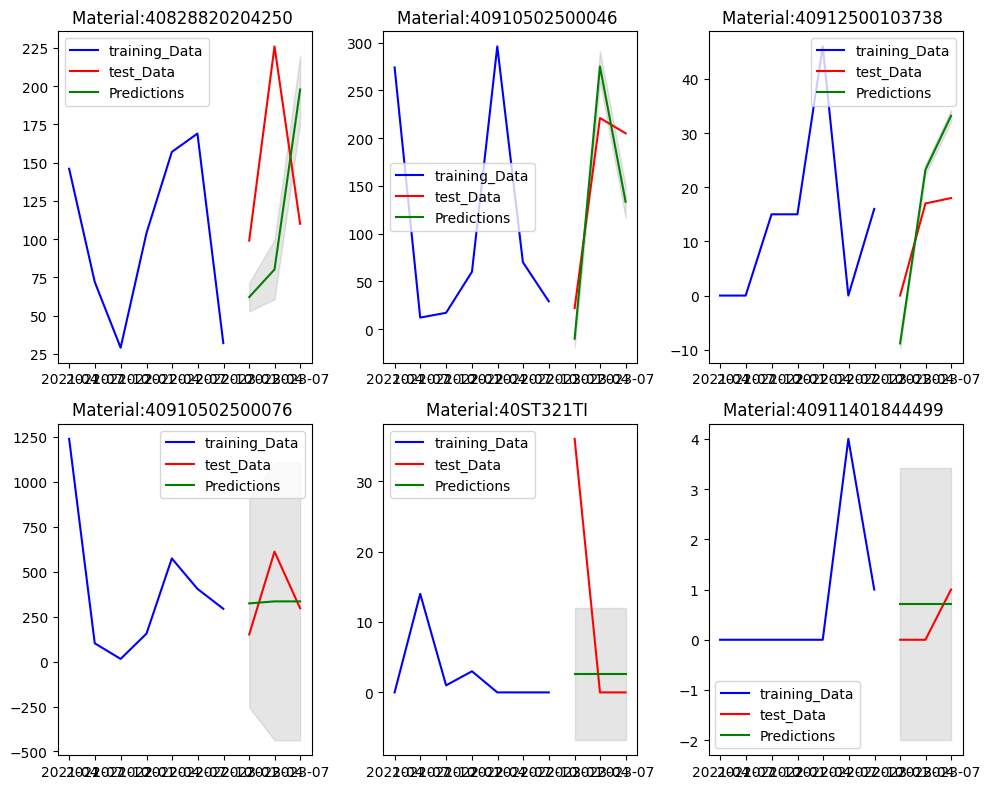

In [42]:
# Define the weight function for the loss function
def weighted_mae(y_true, y_pred):
    diff = np.abs(y_true - y_pred)
    weight = np.square(diff) / np.mean(np.square(diff))
    return np.mean(weight * diff)

fig, axs = plt.subplots(2, 3, figsize=(10, 8))
axs = axs.flatten()

results = []
for i, col in enumerate(train_df.columns):
    # define input
    y = train_df[col]

    # perform ARIMA model selection
    final_aic = np.inf
    final_order = (0, 0, 0)
    for p in range(5):
        for q in range(5):
            try:
                current_aic = ARIMA(y, order=(p, 0, q)).fit().aic
                if current_aic < final_aic:
                    final_aic = current_aic
                    final_order = (p, 0, q)
            except:
                pass

    # fit final model
    final_arma = ARIMA(y, order=final_order).fit()

    # predict future values
    y_pred = final_arma.get_forecast(steps=len(test_df.index))
    y_pred_df = y_pred.conf_int(alpha=0.05)
    y_pred_df['Predictions'] = final_arma.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
    y_pred_df.index = test_df.index

    # plot predictions
    ax = axs[i]
    ax.plot(train_df[col], color='blue', label='training_Data')
    ax.plot(test_df[col], color='red', label='test_Data')
    ax.plot(y_pred_df['Predictions'], color='green', label='Predictions')
    ax.fill_between(y_pred_df.index, y_pred_df.iloc[:, 0], y_pred_df.iloc[:, 1], color='gray', alpha=0.2)
    ax.set_title(f'Material:{col} ')
    ax.legend()
    plt.tight_layout()

    # calculate RMSE and weighted MAE
    rmse = np.sqrt(mean_squared_error(test_df[col], y_pred_df['Predictions']))
    weighted_mae_loss = weighted_mae(test_df[col], y_pred_df['Predictions'])
    aic = final_arma.aic
    bic = final_arma.bic
    results.append([col, rmse, weighted_mae_loss, aic, bic])

In [43]:
# create table
results_df = pd.DataFrame(results, columns=['col', 'RMSE', 'W_MAE', 'AIC', 'BIC'])
print(results_df)

              col        RMSE       W_MAE         AIC         BIC
0  40828820204250  100.570326  126.213950   71.858628   71.479999
1  40910502500046   55.057670   61.549541   72.410829   72.086290
2  40912500103738   10.759329   12.756398   50.570319   50.137600
3  40910502500076  189.799992  244.960753  106.763851  106.601581
4       40ST321TI   19.413862   33.067676   45.757474   45.649294
5  40911401844499    0.606088    0.682534   28.425461   28.317281


**Built model with full data and predict future values**

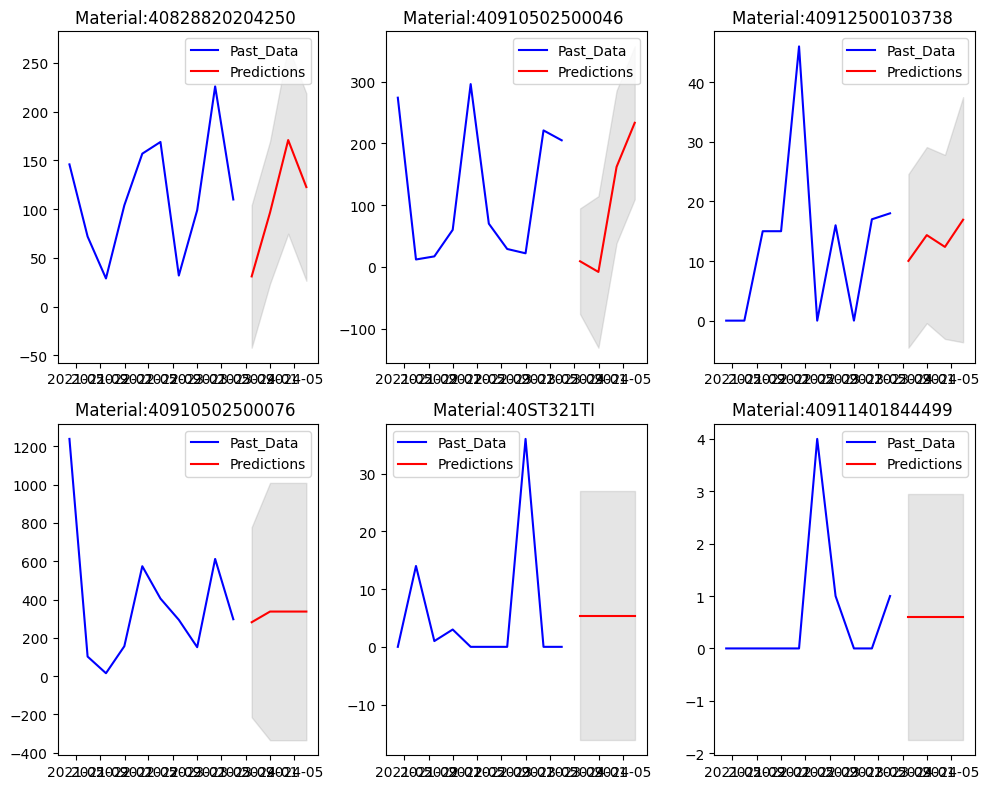

In [44]:
fig, axs = plt.subplots(2, 3, figsize=(10, 8))
axs = axs.flatten()

predictions_df = pd.DataFrame()

for i, col in enumerate(train_df.columns):
    # define input
    y = train_df[col]

    # perform ARIMA model selection
    final_aic = np.inf
    final_order = (0, 0, 0)
    for p in range(5):
        for q in range(5):
            try:
                current_aic = ARIMA(y, order=(p, 0, q)).fit().aic
                if current_aic < final_aic:
                    final_aic = current_aic
                    final_order = (p, 0, q)
            except:
                pass

    # fit final model
    y_full = df_ARIMA_A[col]
    final_arma = ARIMA(y_full, order=final_order).fit()

    # predict future values
    y_pred = final_arma.get_forecast(steps=4)
    y_pred_df = y_pred.conf_int(alpha=0.05)
    y_pred_df['Predictions'] = final_arma.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])

    # append predicted values to predictions_df
    predictions_df = pd.concat([predictions_df, y_pred_df['Predictions']], axis=1)
    predictions_df = predictions_df.rename(columns={'Predictions': col})

    # plot predictions
    ax = axs[i]
    ax.plot(df_ARIMA_A[col], color='blue', label='Past_Data')
    ax.plot(y_pred_df['Predictions'], color='red', label='Predictions')
    ax.fill_between(y_pred_df.index, y_pred_df.iloc[:, 0], y_pred_df.iloc[:, 1], color='gray', alpha=0.2)
    ax.set_title(f'Material:{col} ')
    ax.legend()
    plt.tight_layout()

# set the index of predictions_df to the dates of the predicted values
dates = ['9/30/2023', '12/31/2023', '3/31/2024', '6/30/2024']
predictions_df.index = pd.to_datetime(dates)



### ARIMA Model based on the best MAE

In [45]:
# SPLIT INTO TRAIN TEST
# Set the date range for the test set
test_start_date = '2022-12-31'
test_end_date = '2023-6-30'

# Split the DataFrame into a training set and a test set based on date
train_df = df_ARIMA_M.loc[df_ARIMA_M.index < test_start_date]
test_df = df_ARIMA_M.loc[(df_ARIMA_M.index >= test_start_date) & (df_ARIMA_M.index <= test_end_date)]

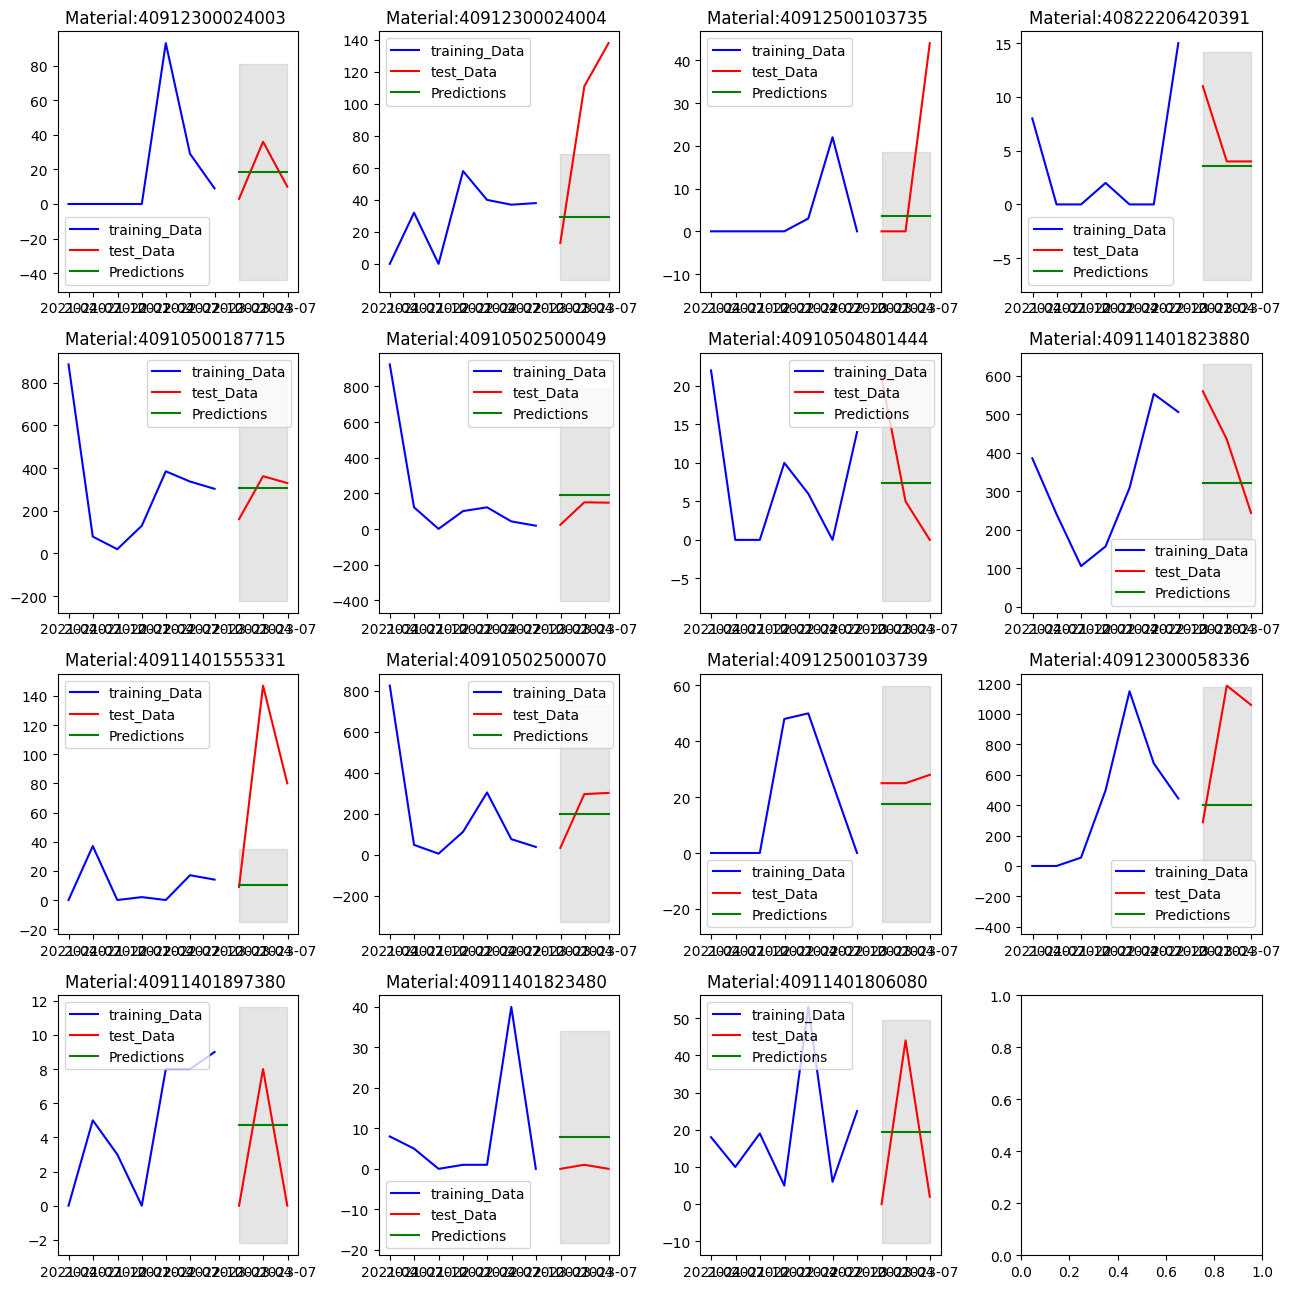

In [46]:
# Define the weight function for the loss function
def weighted_mae(y_true, y_pred):
    diff = np.abs(y_true - y_pred)
    weight = np.square(diff) / np.mean(np.square(diff))
    return np.mean(weight * diff)

fig, axs = plt.subplots(4, 4, figsize=(13, 13))
axs = axs.flatten()

results = []
for i, col in enumerate(train_df.columns):
    # define input
    y = train_df[col]

    # perform ARIMA model selection based on weighted MAE loss function
    final_aic = np.inf
    final_order = (0, 0, 0)
    for p in range(5):
        for q in range(5):
            try:
                current_model = ARIMA(y, order=(p, 0, q)).fit()
                current_weighted_mae_loss = weighted_mae(y[-len(test_df):], current_model.forecast(len(test_df)))
                if current_weighted_mae_loss < final_weighted_mae_loss:
                    final_weighted_mae_loss = current_weighted_mae_loss
                    final_order = (p, 0, q)
            except:
                pass

    # fit final model
    final_arma = sm.tsa.arima.ARIMA(y, order=final_order).fit()

    # predict future values
    y_pred = final_arma.get_forecast(steps=len(test_df.index))
    y_pred_df = y_pred.conf_int(alpha=0.05)
    y_pred_df['Predictions'] = final_arma.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
    y_pred_df.index = test_df.index

    # plot predictions
    ax = axs[i]
    ax.plot(train_df[col], color='blue', label='training_Data')
    ax.plot(test_df[col], color='red', label='test_Data')
    ax.plot(y_pred_df['Predictions'], color='green', label='Predictions')
    ax.fill_between(y_pred_df.index, y_pred_df.iloc[:, 0], y_pred_df.iloc[:, 1], color='gray', alpha=0.2)
    ax.set_title(f'Material:{col} ')
    ax.legend()
    plt.tight_layout()

    # calculate RMSE and weighted MAE
    rmse = np.sqrt(mean_squared_error(test_df[col], y_pred_df['Predictions']))
    weighted_mae_loss = weighted_mae(test_df[col], y_pred_df['Predictions'])
    aic = final_arma.aic
    bic = final_arma.bic
    results.append([col, rmse, weighted_mae_loss, aic, bic])

In [47]:
# create table
results_df = pd.DataFrame(results, columns=['col', 'RMSE', 'W_MAE', 'AIC', 'BIC'])
print(results_df)

               col        RMSE       W_MAE         AIC         BIC
0   40912300024003   14.395293   15.614500   72.337848   72.229668
1   40912300024004   79.080648   97.798204   65.798960   65.690780
2   40912500103735   23.522896   39.862165   52.248720   52.140541
3   40822206420391    4.303142    7.382286   47.460798   47.352618
4   40910500187715   90.737904  130.496639  102.210209  102.102030
5   40910502500049  101.638117  152.485017  103.839577  103.731398
6   40910504801444    9.041853   11.921361   52.685612   52.577432
7   40911401823880  158.309804  203.370064   94.627330   94.519150
8   40911401555331   88.825676  123.124381   59.624916   59.516736
9   40910502500070  125.743449  139.922322  102.282363  102.174183
10  40912500103739    8.546397    8.917540   66.886691   66.778511
11  40912300058336  593.649465  722.955742  107.535902  107.427723
12  40911401897380    4.291264    4.435111   41.539523   41.431344
13  40911401823480    7.538558    7.581342   60.209485   60.10

**Built model with full data and predict future values**

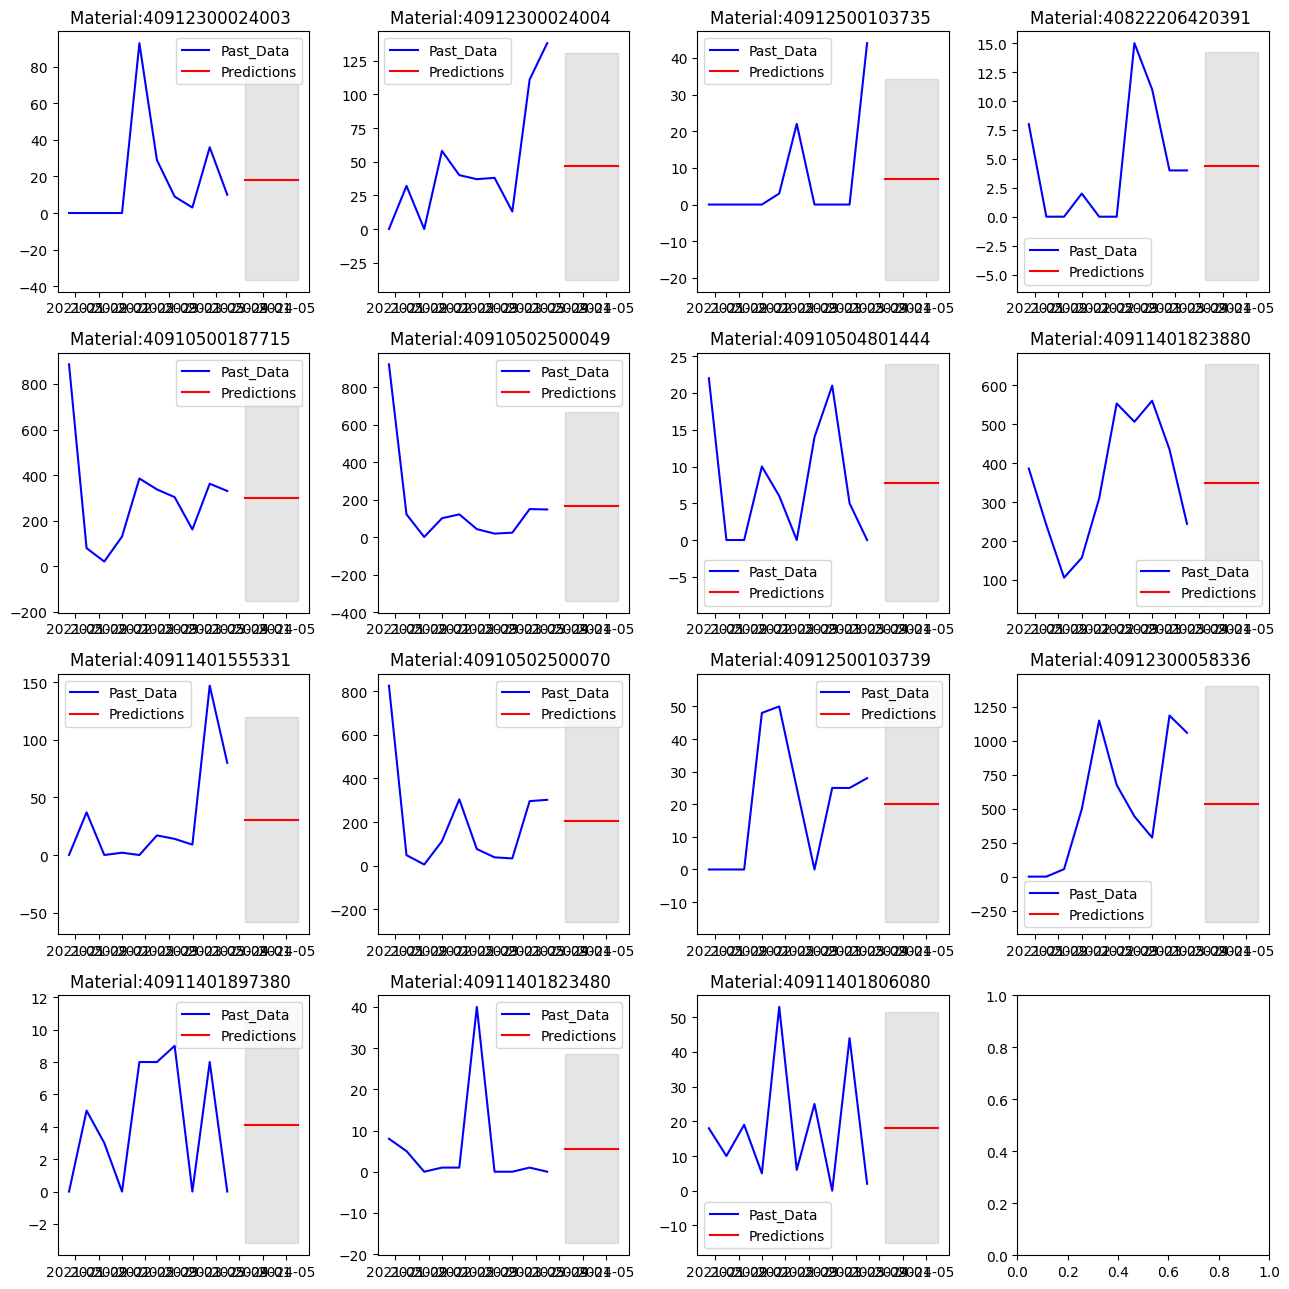

In [48]:
fig, axs = plt.subplots(4, 4, figsize=(13, 13))
axs = axs.flatten()

predictions_df_1 = pd.DataFrame()
for i, col in enumerate(train_df.columns):
    # define input
    y = train_df[col]

    # perform ARIMA model selection based on weighted MAE loss function
    final_aic = np.inf
    final_order = (0, 0, 0)
    for p in range(5):
        for q in range(5):
            try:
                current_model = ARIMA(y, order=(p, 0, q)).fit()
                current_weighted_mae_loss = weighted_mae(y[-len(test_df):], current_model.forecast(len(test_df)))
                if current_weighted_mae_loss < final_weighted_mae_loss:
                    final_weighted_mae_loss = current_weighted_mae_loss
                    final_order = (p, 0, q)
            except:
                pass

    # fit final model
    y_full = df_ARIMA_M[col]
    final_arma = sm.tsa.arima.ARIMA(y_full, order=final_order).fit()

    # predict future values
    y_pred = final_arma.get_forecast(steps=4)
    y_pred_df = y_pred.conf_int(alpha=0.05)
    y_pred_df['Predictions'] = final_arma.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])

     # append predicted values to predictions_df
    predictions_df_1 = pd.concat([predictions_df_1, y_pred_df['Predictions']], axis=1)
    predictions_df_1 = predictions_df_1.rename(columns={'Predictions': col})

    # plot predictions
    ax = axs[i]
    ax.plot(df_ARIMA_M[col], color='blue', label='Past_Data')
    ax.plot(y_pred_df['Predictions'], color='red', label='Predictions')
    ax.fill_between(y_pred_df.index, y_pred_df.iloc[:, 0], y_pred_df.iloc[:, 1], color='gray', alpha=0.2)
    ax.set_title(f'Material:{col} ')
    ax.legend()
    plt.tight_layout()


# set the index of predictions_df to the dates of the predicted values
dates = ['9/30/2023', '12/31/2023', '3/31/2024', '6/30/2024']
predictions_df_1.index = pd.to_datetime(dates)

### ARMA Model based on the best AIC

In [49]:
# SPLIT INTO TRAIN TEST
# Set the date range for the test set
test_start_date = '2022-12-31'
test_end_date = '2023-6-30'

# Split the DataFrame into a training set and a test set based on date
train_df = df_ARMA_A.loc[df_ARMA_A.index < test_start_date]
test_df = df_ARMA_A.loc[(df_ARMA_A.index >= test_start_date) & (df_ARMA_A.index <= test_end_date)]

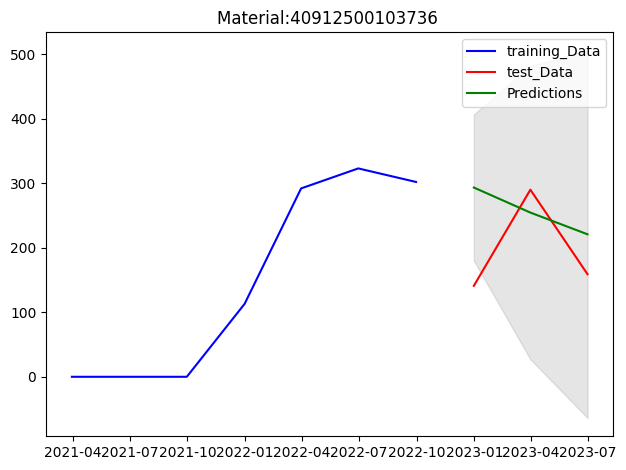

In [50]:
# Define the weight function for the loss function
def weighted_mae(y_true, y_pred):
    diff = np.abs(y_true - y_pred)
    weight = np.square(diff) / np.mean(np.square(diff))
    return np.mean(weight * diff)

# define input
col = train_df.columns[0]
y = train_df[col]

# perform ARMA model selection
final_aic = np.inf
final_order = (0, 0, 0)

for p in range(5):
    for q in range(5):
        try:
            current_aic = SARIMAX(y, order=(p, 0, q)).fit().aic
            if current_aic < final_aic:
                final_aic = current_aic
                final_order = (p, 0, q)
        except:
            pass

# fit final model
final_arma = SARIMAX(y, order=final_order).fit()

# predict future values
y_pred = final_arma.get_forecast(steps=len(test_df.index))
y_pred_df = y_pred.conf_int(alpha=0.05)
y_pred_df['Predictions'] = final_arma.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
y_pred_df.index = test_df.index

# plot predictions
plt.plot(train_df[col], color='blue', label='training_Data')
plt.plot(test_df[col], color='red', label='test_Data')
plt.plot(y_pred_df['Predictions'], color='green', label='Predictions')
plt.fill_between(y_pred_df.index, y_pred_df.iloc[:, 0], y_pred_df.iloc[:, 1], color='gray', alpha=0.2)
plt.title(f'Material:{col} ')
plt.legend()
plt.tight_layout()

# calculate RMSE and weighted MAE
rmse = np.sqrt(mean_squared_error(test_df[col], y_pred_df['Predictions']))
weighted_mae_loss = weighted_mae(test_df[col], y_pred_df['Predictions'])
aic = final_arma.aic
bic = final_arma.bic

results = [[col, rmse, weighted_mae_loss, aic, bic]]



In [51]:
# create table
results_df = pd.DataFrame(results, columns=['col', 'RMSE', 'W_MAE', 'AIC', 'BIC'])
print(results_df)

              col       RMSE       W_MAE        AIC        BIC
0  40912500103736  97.117256  134.918819  86.351544  86.189274


**Built model with full data and predict future values**

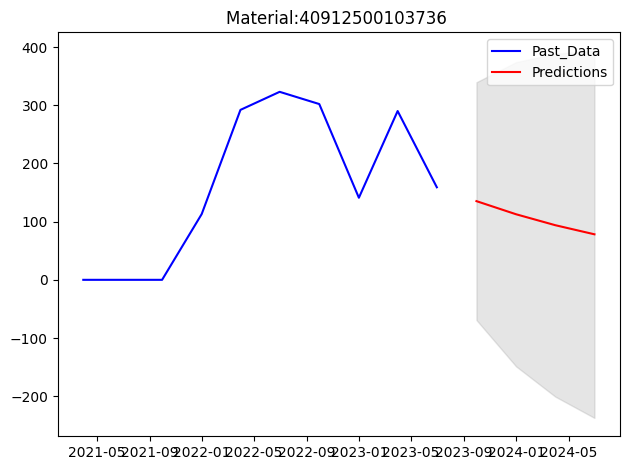

In [52]:
# define input
col = train_df.columns[0]
y = train_df[col]

# perform ARMA model selection
final_aic = np.inf
final_order = (0, 0, 0)

for p in range(5):
    for q in range(5):
        try:
            current_aic = SARIMAX(y, order=(p, 0, q)).fit().aic
            if current_aic < final_aic:
                final_aic = current_aic
                final_order = (p, 0, q)
        except:
            pass

# fit final model
col = df_ARMA_A.columns[0]
y = df_ARMA_A[col]
final_arma = SARIMAX(y, order=final_order).fit()

# predict future values
y_pred = final_arma.get_forecast(steps=4)
y_pred_df = y_pred.conf_int(alpha=0.05)
y_pred_df['Predictions'] = final_arma.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])

# append predicted values to predictions_df
predictions_df_2 = pd.DataFrame()
predictions_df_2 = pd.concat([predictions_df_2, y_pred_df['Predictions']], axis=1)
predictions_df_2 = predictions_df_2.rename(columns={'Predictions': col})

# set the index of predictions_df to the dates of the predicted values
dates = ['9/30/2023', '12/31/2023', '3/31/2024', '6/30/2024']
predictions_df_2.index = pd.to_datetime(dates)

# plot predictions
plt.plot(df_ARMA_A[col], color='blue', label='Past_Data')
plt.plot(y_pred_df['Predictions'], color='red', label='Predictions')
plt.fill_between(y_pred_df.index, y_pred_df.iloc[:, 0], y_pred_df.iloc[:, 1], color='gray', alpha=0.2)
plt.title(f'Material:{col} ')
plt.legend()
plt.tight_layout()

### ARMA Model based on the best MAE


In [53]:
# SPLIT INTO TRAIN TEST
# Set the date range for the test set
test_start_date = '2022-12-31'
test_end_date = '2023-6-30'

# Split the DataFrame into a training set and a test set based on date
train_df = df_ARMA_M.loc[df_ARMA_M.index < test_start_date]
test_df = df_ARMA_M.loc[(df_ARMA_M.index >= test_start_date) & (df_ARMA_M.index <= test_end_date)]

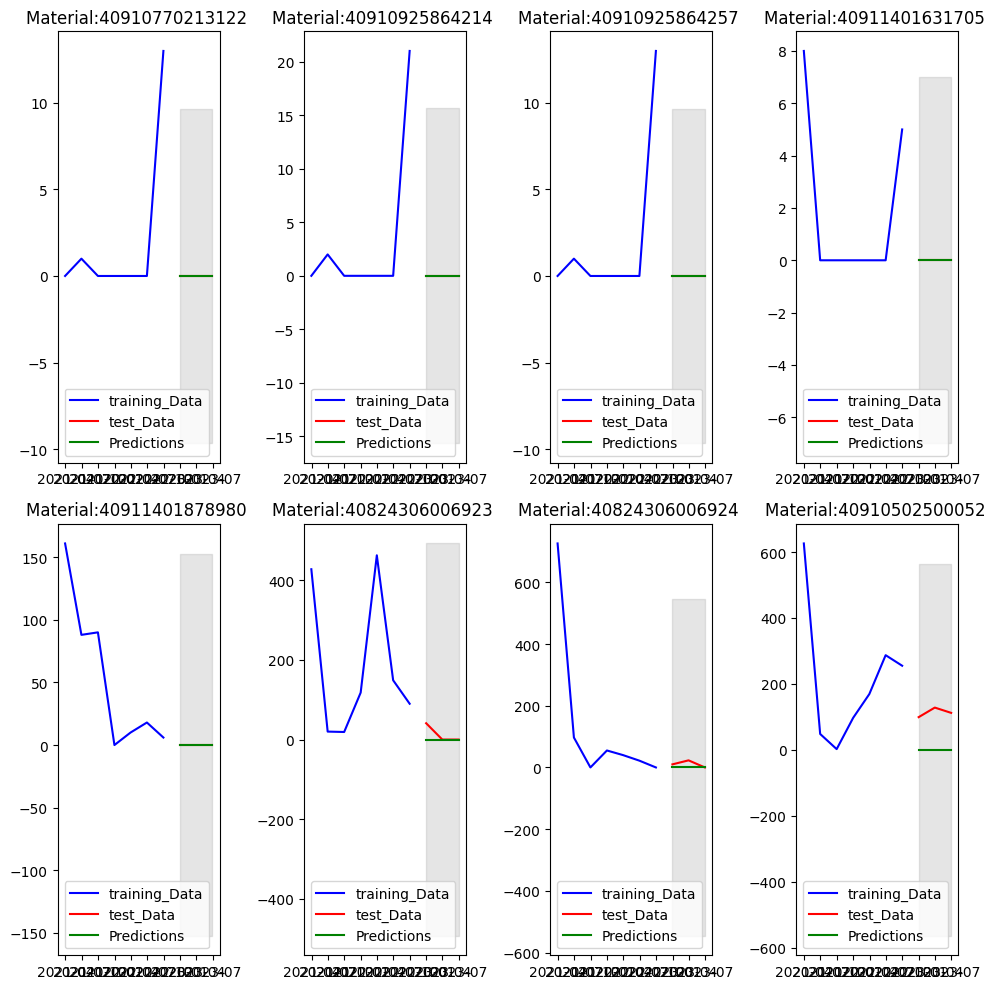

In [54]:
# Define the weight function for the loss function
def weighted_mae(y_true, y_pred):
    diff = np.abs(y_true - y_pred)
    weight = np.square(diff) / np.mean(np.square(diff))
    return np.mean(weight * diff)

fig, axs = plt.subplots(2, 4, figsize=(10, 10))
axs = axs.flatten()

results = []
for i, col in enumerate(train_df.columns):
    # define input
    y = train_df[col]

    # perform ARIMA model selection based on weighted MAE loss function
    final_aic = np.inf
    final_order = (0, 0, 0)
    for p in range(5):
        for q in range(5):
            try:
                current_model = SARIMAX(y, order=(p, 0, q)).fit()
                current_weighted_mae_loss = weighted_mae(y[-len(test_df):], current_model.forecast(len(test_df)))
                if current_weighted_mae_loss < final_weighted_mae_loss:
                    final_weighted_mae_loss = current_weighted_mae_loss
                    final_order = (p, 0, q)
            except:
                pass

    # fit final model
    final_arma = SARIMAX(y, order=final_order).fit()

    # predict future values
    y_pred = final_arma.get_forecast(steps=len(test_df.index))
    y_pred_df = y_pred.conf_int(alpha=0.05)
    y_pred_df['Predictions'] = final_arma.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
    y_pred_df.index = test_df.index

    # plot predictions
    ax = axs[i]
    ax.plot(train_df[col], color='blue', label='training_Data')
    ax.plot(test_df[col], color='red', label='test_Data')
    ax.plot(y_pred_df['Predictions'], color='green', label='Predictions')
    ax.fill_between(y_pred_df.index, y_pred_df.iloc[:, 0], y_pred_df.iloc[:, 1], color='gray', alpha=0.2)
    ax.set_title(f'Material:{col} ')
    ax.legend()
    plt.tight_layout()

    # calculate RMSE and weighted MAE
    rmse = np.sqrt(mean_squared_error(test_df[col], y_pred_df['Predictions']))
    weighted_mae_loss = weighted_mae(test_df[col], y_pred_df['Predictions'])
    aic = final_arma.aic
    bic = final_arma.bic
    results.append([col, rmse, weighted_mae_loss, aic, bic])

In [55]:
# create table
results_df = pd.DataFrame(results, columns=['col', 'RMSE', 'W_MAE', 'AIC', 'BIC'])
print(results_df)

              col        RMSE       W_MAE         AIC         BIC
0  40910770213122    0.000000         NaN   44.194357   44.140268
1  40910925864214    0.000000         NaN   50.930288   50.876199
2  40910925864257    0.000000         NaN   44.194357   44.140268
3  40911401631705    0.000000         NaN   39.664223   39.610133
4  40911401878980    0.000000         NaN   82.799143   82.745053
5  40824306006923   23.671361   41.000000   99.245756   99.191666
6  40824306006924   14.479871   20.933227  100.659672  100.605582
7  40910502500052  113.620714  115.478814  101.133795  101.079705


**Built model with full data and predict future values**

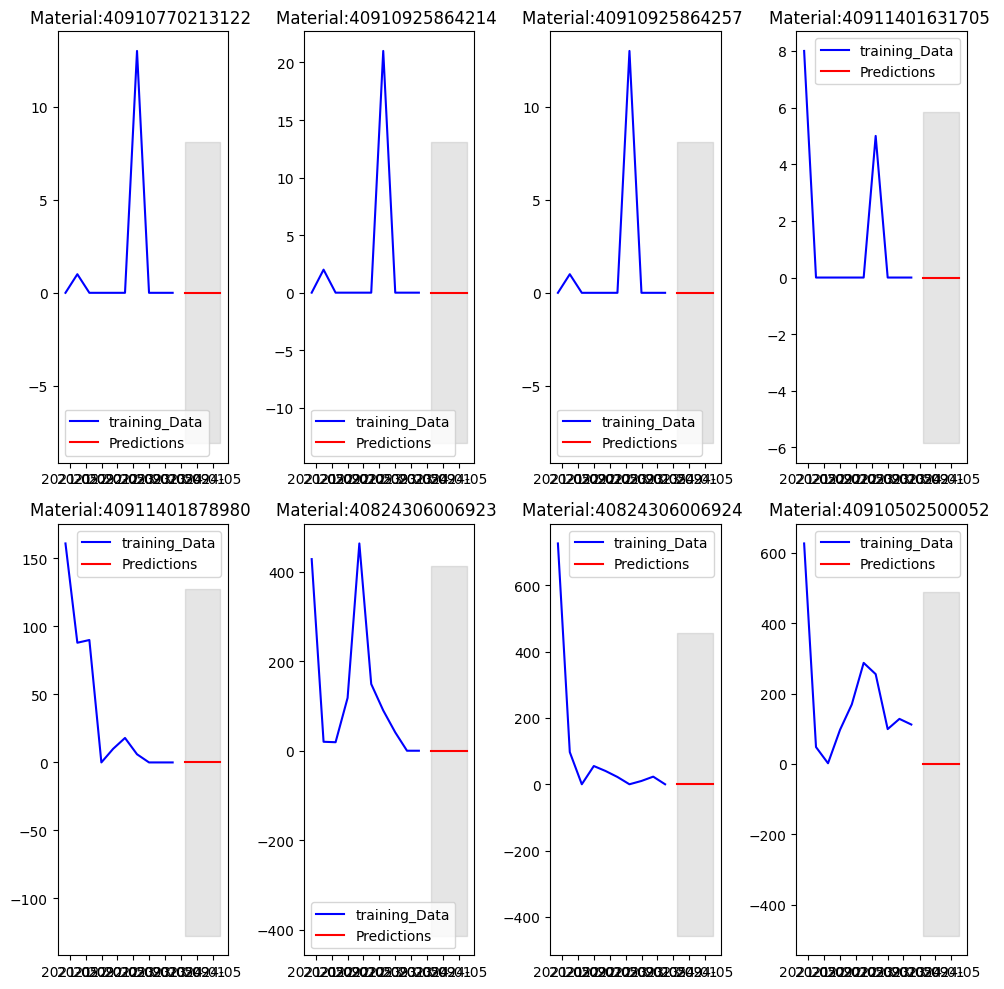

In [56]:
fig, axs = plt.subplots(2, 4, figsize=(10, 10))
axs = axs.flatten()

predictions_df_3 = pd.DataFrame()
for i, col in enumerate(train_df.columns):
    # define input
    y = train_df[col]

    # perform ARIMA model selection based on weighted MAE loss function
    final_aic = np.inf
    final_order = (0, 0, 0)
    for p in range(5):
        for q in range(5):
            try:
                current_model = SARIMAX(y, order=(p, 0, q)).fit()
                current_weighted_mae_loss = weighted_mae(y[-len(test_df):], current_model.forecast(len(test_df)))
                if current_weighted_mae_loss < final_weighted_mae_loss:
                    final_weighted_mae_loss = current_weighted_mae_loss
                    final_order = (p, 0, q)
            except:
                pass

    # fit final model
    y_full = df_ARMA_M[col]
    final_arma = SARIMAX(y_full, order=final_order).fit()

    # predict future values
    y_pred = final_arma.get_forecast(steps=4)
    y_pred_df = y_pred.conf_int(alpha=0.05)
    y_pred_df['Predictions'] = final_arma.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])

    # append predicted values to predictions_df
    predictions_df_3 = pd.concat([predictions_df_3, y_pred_df['Predictions']], axis=1)
    predictions_df_3 = predictions_df_3.rename(columns={'Predictions': col})

    # plot predictions
    ax = axs[i]
    ax.plot(df_ARMA_M[col], color='blue', label='training_Data')
    ax.plot(y_pred_df['Predictions'], color='red', label='Predictions')
    ax.fill_between(y_pred_df.index, y_pred_df.iloc[:, 0], y_pred_df.iloc[:, 1], color='gray', alpha=0.2)
    ax.set_title(f'Material:{col} ')
    ax.legend()
    plt.tight_layout()


# set the index of predictions_df to the dates of the predicted values
dates = ['9/30/2023', '12/31/2023', '3/31/2024', '6/30/2024']
predictions_df_1.index = pd.to_datetime(dates)

### SARMA Model based on the best AIC

In [57]:
# SPLIT INTO TRAIN TEST
# Set the date range for the test set
test_start_date = '2022-12-31'
test_end_date = '2023-6-30'

# Split the DataFrame into a training set and a test set based on date
train_df = df_SARIMA_A.loc[df_SARIMA_A.index < test_start_date]
test_df = df_SARIMA_A.loc[(df_SARIMA_A.index >= test_start_date) & (df_SARIMA_A.index <= test_end_date)]

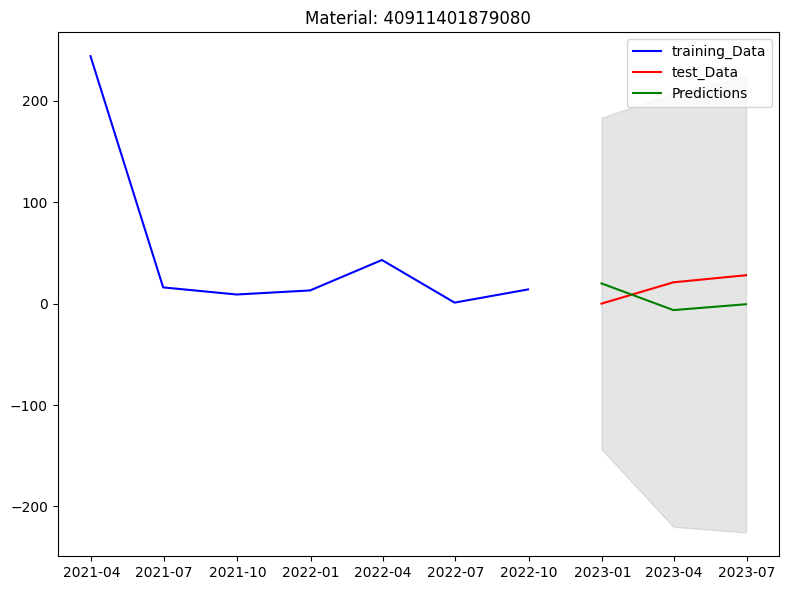

In [58]:
results = []

# Define the weight function for the loss function
def weighted_mae(y_true, y_pred):
  diff = np.abs(y_true - y_pred)
  weight = np.square(diff) / np.mean(np.square(diff))
  return np.mean(weight * diff)

fig, ax = plt.subplots(figsize=(8, 6)) # create a single figure and axis

# define input
col = '40911401879080' # replace 'column_name' with the name of the column you want to use
y = train_df[col]

# perform ARIMA model selection based on weighted MAE loss function
final_aic = np.inf
final_order = (0, 0, 0)

for p in range(5):
  for q in range(5):
    for j in range(5):
      try:
        current_aic = SARIMAX(y, order = (p,q,j), seasonal_order=(1,1,1,4)).fit().aic
        if current_aic < final_aic:
          final_aic = current_aic
          final_order = (p, j, q)
      except:
        pass

# perform seasonal ARIMA model selection based o weigthed MAE loss function
final_Sorder = (0, 0, 0, 4)

for l in range(5):
  for m in range(5):
    for n in range(5):
      try:
        current_aic = SARIMAX(y, order = final_order, seasonal_order=(l,m,n,4)).fit().aic
        if current_aic < final_aic:
          final_aic = current_aic
          final_Sorder = (l, m, n,4)
      except:
        pass

# fit final model
final_arma = SARIMAX(y, order = final_order, seasonal_order=final_Sorder).fit()

# predict future values
y_pred = final_arma.get_forecast(steps=len(test_df.index))
y_pred_df = y_pred.conf_int(alpha=0.05)
y_pred_df['Predictions'] = final_arma.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
y_pred_df.index = test_df.index

# plot predictions
ax.plot(train_df[col], color='blue', label='training_Data')
ax.plot(test_df[col], color='red', label='test_Data')
ax.plot(y_pred_df['Predictions'], color='green', label='Predictions')
ax.fill_between(y_pred_df.index, y_pred_df.iloc[:, 0], y_pred_df.iloc[:, 1], color='gray', alpha=0.2)
ax.set_title(f'Material: {col}')
ax.legend()
plt.tight_layout()

# calculate RMSE and weighted MAE
rmse = np.sqrt(mean_squared_error(test_df[col], y_pred_df['Predictions']))
weighted_mae_loss = weighted_mae(test_df[col], y_pred_df['Predictions'])
aic = final_arma.aic
bic = final_arma.bic

results.append([col, rmse, weighted_mae_loss, aic, bic])

In [59]:
# create table
results_df = pd.DataFrame(results, columns=['col', 'RMSE', 'W_MAE', 'AIC', 'BIC'])
print(results_df)

              col       RMSE      W_MAE        AIC        BIC
0  40911401879080  25.591324  26.383002  91.191028  90.974669


**Built model with full data and predict future values**


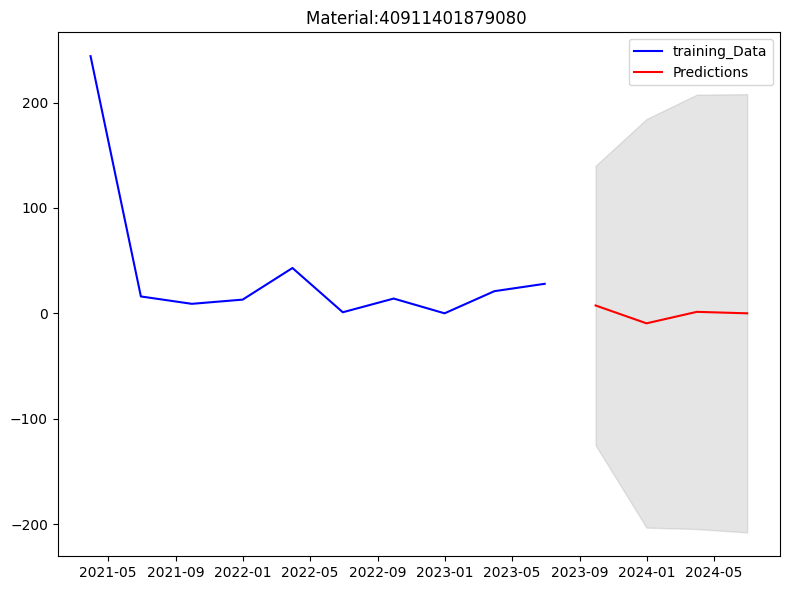

In [60]:
fig, ax = plt.subplots(figsize=(8, 6)) # create a single figure and axis

# define input
col = '40911401879080' # replace 'column_name' with the name of the column you want to use
y = train_df[col]

# perform ARIMA model selection based on weighted MAE loss function
final_aic = np.inf
final_order = (0, 0, 0)
for p in range(5):
  for q in range(5):
    for j in range(5):
      try:
        current_aic = SARIMAX(y, order = (p,q,j), seasonal_order=(1,1,1,4)).fit().aic
        if current_aic < final_aic:
          final_aic = current_aic
          final_order = (p, j, q)
      except:
        pass

# perform seasonal ARIMA model selection based o weigthed MAE loss function
final_Sorder = (0, 0, 0, 4)
for l in range(5):
  for m in range(5):
    for n in range(5):
      try:
        current_aic = SARIMAX(y, order = final_order, seasonal_order=(l,m,n,4)).fit().aic
        if current_aic < final_aic:
          final_aic = current_aic
          final_Sorder = (l, m, n,4)
      except:
        pass

# fit final model
y_full = df_SARIMA_A[col]
final_arma = SARIMAX(y_full, order = final_order, seasonal_order=final_Sorder).fit()

# predict future values
y_pred = final_arma.get_forecast(steps=4)
y_pred_df = y_pred.conf_int(alpha=0.05)
y_pred_df['Predictions'] = final_arma.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])

# append predicted values to predictions_df
predictions_df_4 = pd.DataFrame()
predictions_df_4 = pd.concat([predictions_df_4, y_pred_df['Predictions']], axis=1)
predictions_df_4 = predictions_df_4.rename(columns={'Predictions': col})

# set the index of predictions_df to the dates of the predicted values
dates = ['9/30/2023', '12/31/2023', '3/31/2024', '6/30/2024']
predictions_df_4.index = pd.to_datetime(dates)

# plot predictions
ax.plot(df_SARIMA_A[col], color='blue', label='training_Data')
ax.plot(y_pred_df['Predictions'], color='red', label='Predictions')
ax.fill_between(y_pred_df.index, y_pred_df.iloc[:, 0], y_pred_df.iloc[:, 1], color='gray', alpha=0.2)
ax.set_title(f'Material:{col} ')
ax.legend()
plt.tight_layout()

### SARIMA Model based on the best MAE

In [61]:
# SPLIT INTO TRAIN TEST
# Set the date range for the test set
test_start_date = '2022-12-31'
test_end_date = '2023-6-30'

# Split the DataFrame into a training set and a test set based on date
train_df = df_SARIMA_M.loc[df_SARIMA_M.index < test_start_date]
test_df = df_SARIMA_M.loc[(df_SARIMA_M.index >= test_start_date) & (df_SARIMA_M.index <= test_end_date)]

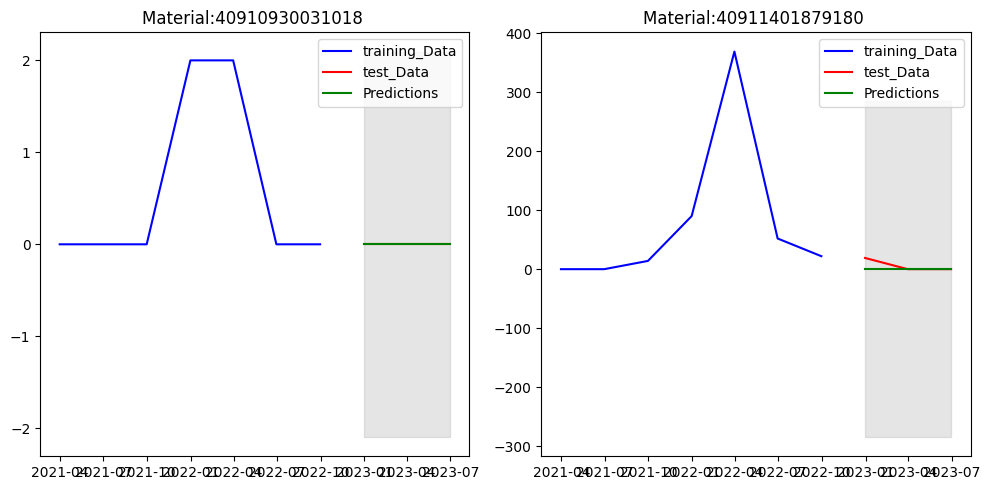

In [62]:
results = []
# Define the weight function for the loss function
def weighted_mae(y_true, y_pred):
    diff = np.abs(y_true - y_pred)
    weight = np.square(diff) / np.mean(np.square(diff))
    return np.mean(weight * diff)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.flatten()

results = []
for i, col in enumerate(train_df.columns):
    # define input
    y = train_df[col]

    # perform ARIMA model selection based on weighted MAE loss function
    final_aic = np.inf
    final_order = (0, 0, 0)
    for p in range(5):
        for q in range(5):
          for j in range(5):
            try:
                current_model = SARIMAX(y, order = (p,q,j), seasonal_order=(1,1,1,4)).fit()
                current_weighted_mae_loss = weighted_mae(y[-len(test_df):], current_model.forecast(len(test_df)))
                if current_weighted_mae_loss < final_weighted_mae_loss:
                    final_weighted_mae_loss = current_weighted_mae_loss
                    final_order = (p, j, q)
            except:
                pass

    # perform seasonal ARIMA model selection based o weigthed MAE loss function
    final_Sorder = (0, 0, 0, 4)
    for l in range(5):
        for m in range(5):
          for n in range(5):
            try:
                current_model = SARIMAX(y, order = final_order, seasonal_order=(l,m,n,4)).fit()
                current_weighted_mae_loss = weighted_mae(y[-len(test_df):], current_model.forecast(len(test_df)))
                if current_weighted_mae_loss < final_weighted_mae_loss:
                    final_weighted_mae_loss = current_weighted_mae_loss
                    final_Sorder = (l, m, n,4)
            except:
                pass

    # fit final model
        final_arma = SARIMAX(y, order = final_order, seasonal_order=final_Sorder).fit()

    # predict future values
    y_pred = final_arma.get_forecast(steps=len(test_df.index))
    y_pred_df = y_pred.conf_int(alpha=0.05)
    y_pred_df['Predictions'] = final_arma.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
    y_pred_df.index = test_df.index

    # plot predictions
    ax = axs[i]
    ax.plot(train_df[col], color='blue', label='training_Data')
    ax.plot(test_df[col], color='red', label='test_Data')
    ax.plot(y_pred_df['Predictions'], color='green', label='Predictions')
    ax.fill_between(y_pred_df.index, y_pred_df.iloc[:, 0], y_pred_df.iloc[:, 1], color='gray', alpha=0.2)
    ax.set_title(f'Material:{col} ')
    ax.legend()
    plt.tight_layout()

    # calculate RMSE and weighted MAE
    rmse = np.sqrt(mean_squared_error(test_df[col], y_pred_df['Predictions']))
    weighted_mae_loss = weighted_mae(test_df[col], y_pred_df['Predictions'])
    aic = final_arma.aic
    bic = final_arma.bic
    results.append([col, rmse, weighted_mae_loss, aic, bic])

In [63]:
# create table
results_df = pd.DataFrame(results, columns=['col', 'RMSE', 'W_MAE', 'AIC', 'BIC'])
print(results_df)

              col       RMSE  W_MAE        AIC        BIC
0  40910930031018   0.000000    NaN  22.799859  22.745769
1  40911401879180  10.969655   19.0  91.561731  91.507641


**Built model with full data and predict future values**

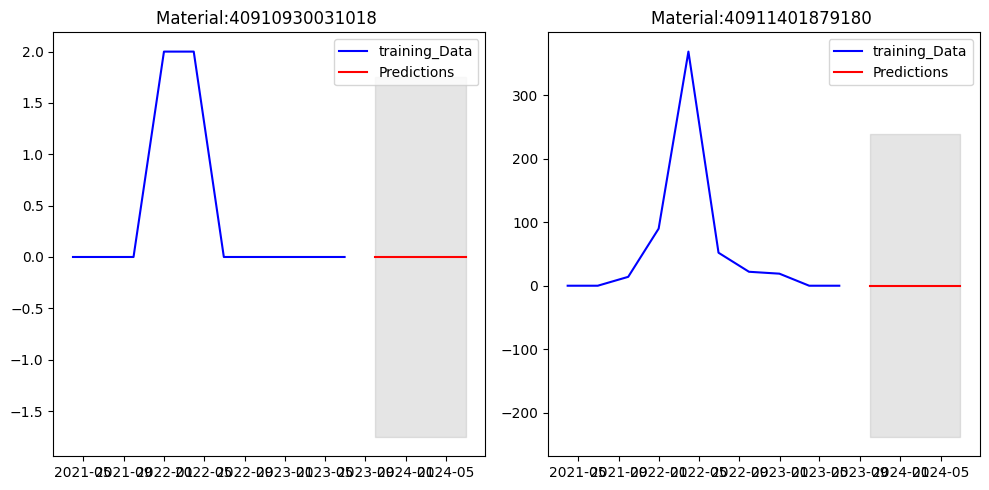

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.flatten()
predictions_df_5 =pd.DataFrame()

for i, col in enumerate(train_df.columns):
    # define input
    y = train_df[col]

    # perform ARIMA model selection based on weighted MAE loss function
    final_aic = np.inf
    final_order = (0, 0, 0)
    for p in range(5):
        for q in range(5):
          for j in range(5):
            try:
                current_model = SARIMAX(y, order = (p,q,j), seasonal_order=(1,1,1,4)).fit()
                current_weighted_mae_loss = weighted_mae(y[-len(test_df):], current_model.forecast(len(test_df)))
                if current_weighted_mae_loss < final_weighted_mae_loss:
                    final_weighted_mae_loss = current_weighted_mae_loss
                    final_order = (p, j, q)
            except:
                pass

    # perform seasonal ARIMA model selection based o weigthed MAE loss function
    final_Sorder = (0, 0, 0, 4)
    for l in range(5):
        for m in range(5):
          for n in range(5):
            try:
                current_model = SARIMAX(y, order = final_order, seasonal_order=(l,m,n,4)).fit()
                current_weighted_mae_loss = weighted_mae(y[-len(test_df):], current_model.forecast(len(test_df)))
                if current_weighted_mae_loss < final_weighted_mae_loss:
                    final_weighted_mae_loss = current_weighted_mae_loss
                    final_Sorder = (l, m, n,4)
            except:
                pass

    # fit final model
    y_full =df_SARIMA_M[col]
    final_arma = SARIMAX(y_full, order = final_order, seasonal_order=final_Sorder).fit()

    # predict future values
    y_pred = final_arma.get_forecast(steps=4)
    y_pred_df = y_pred.conf_int(alpha=0.05)
    y_pred_df['Predictions'] = final_arma.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])

    # append predicted values to predictions_df
    predictions_df_5 = pd.concat([predictions_df_5, y_pred_df['Predictions']], axis=1)
    predictions_df_5 = predictions_df_5.rename(columns={'Predictions': col})

    # plot predictions
    ax = axs[i]
    ax.plot(df_SARIMA_M[col], color='blue', label='training_Data')
    ax.plot(y_pred_df['Predictions'], color='red', label='Predictions')
    ax.fill_between(y_pred_df.index, y_pred_df.iloc[:, 0], y_pred_df.iloc[:, 1], color='gray', alpha=0.2)
    ax.set_title(f'Material:{col} ')
    ax.legend()
    plt.tight_layout()

# set the index of predictions_df to the dates of the predicted values
dates = ['9/30/2023', '12/31/2023', '3/31/2024', '6/30/2024']
predictions_df_5.index = pd.to_datetime(dates)

## Join Predictions into a single DF


In [65]:
predictions = pd.concat([predictions_df,predictions_df_1,predictions_df_2,predictions_df_3,predictions_df_4,predictions_df_5], axis=1)
predictions

40828820204250  40910502500046  40912500103738  \
2023-09-30 00:00:00       31.094855        9.119359       10.019423   
2023-12-31 00:00:00       96.607858       -8.163290       14.344463   
2024-03-31 00:00:00      170.950507      161.937680       12.366882   
2024-06-30 00:00:00      122.713286      233.344947       16.926044   

                     40910502500076  40ST321TI  40911401844499  \
2023-09-30 00:00:00      281.364585   5.399995        0.599994   
2023-12-31 00:00:00      337.136455   5.399995        0.599994   
2024-03-31 00:00:00      337.136455   5.399995        0.599994   
2024-06-30 00:00:00      337.136455   5.399995        0.599994   

                     40912300024003  40912300024004  40912500103735  \
2023-09-30 00:00:00       17.999995       46.699995        6.899995   
2023-12-31 00:00:00       17.999995       46.699995        6.899995   
2024-03-31 00:00:00       17.999995       46.699995        6.899995   
2024-06-30 00:00:00       17.999995       46.699995        6.899995   

                     40822206420391  ...  40910925864214  40910925864257  \
2023-09-30 00:00:00        4.399994  ...             0.0             0.0   
2023-12-31 00:00:00        4.399994  ...             0.0             0.0   
2024-03-31 00:00:00        4.399994  ...             0.0             0.0   
2024-06-30 00:00:00        4.399994  ...             0.0             0.0   

                     40911401631705  40911401878980  40824306006923  \
2023-09-30 00:00:00             0.0             0.0             0.0   
2023-12-31 00:00:00             0.0             0.0             0.0   
2024-03-31 00:00:00             0.0             0.0             0.0   
2024-06-30 00:00:00             0.0             0.0             0.0   

                     40824306006924  40910502500052  40911401879080  \
2023-09-30 00:00:00             0.0             0.0        7.433079   
2023-12-31 00:00:00             0.0             0.0       -9.509505   
2024-03-31 00:00:00             0.0             0.0        1.392412   
2024-06-30 00:00:00             0.0             0.0        0.000000   

                     40910930031018  40911401879180  
2023-09-30 00:00:00             0.0             0.0  
2023-12-31 00:00:00             0.0             0.0  
2024-03-31 00:00:00             0.0             0.0  
2024-06-30 00:00:00             0.0             0.0  

[4 rows x 33 columns]

In [66]:
predictions = np.ceil(predictions)
predictions

40828820204250  40910502500046  40912500103738  \
2023-09-30 00:00:00            32.0            10.0            11.0   
2023-12-31 00:00:00            97.0            -8.0            15.0   
2024-03-31 00:00:00           171.0           162.0            13.0   
2024-06-30 00:00:00           123.0           234.0            17.0   

                     40910502500076  40ST321TI  40911401844499  \
2023-09-30 00:00:00           282.0        6.0             1.0   
2023-12-31 00:00:00           338.0        6.0             1.0   
2024-03-31 00:00:00           338.0        6.0             1.0   
2024-06-30 00:00:00           338.0        6.0             1.0   

                     40912300024003  40912300024004  40912500103735  \
2023-09-30 00:00:00            18.0            47.0             7.0   
2023-12-31 00:00:00            18.0            47.0             7.0   
2024-03-31 00:00:00            18.0            47.0             7.0   
2024-06-30 00:00:00            18.0            47.0             7.0   

                     40822206420391  ...  40910925864214  40910925864257  \
2023-09-30 00:00:00             5.0  ...             0.0             0.0   
2023-12-31 00:00:00             5.0  ...             0.0             0.0   
2024-03-31 00:00:00             5.0  ...             0.0             0.0   
2024-06-30 00:00:00             5.0  ...             0.0             0.0   

                     40911401631705  40911401878980  40824306006923  \
2023-09-30 00:00:00             0.0             0.0             0.0   
2023-12-31 00:00:00             0.0             0.0             0.0   
2024-03-31 00:00:00             0.0             0.0             0.0   
2024-06-30 00:00:00             0.0             0.0             0.0   

                     40824306006924  40910502500052  40911401879080  \
2023-09-30 00:00:00             0.0             0.0             8.0   
2023-12-31 00:00:00             0.0             0.0            -9.0   
2024-03-31 00:00:00             0.0             0.0             2.0   
2024-06-30 00:00:00             0.0             0.0             0.0   

                     40910930031018  40911401879180  
2023-09-30 00:00:00             0.0             0.0  
2023-12-31 00:00:00             0.0             0.0  
2024-03-31 00:00:00             0.0             0.0  
2024-06-30 00:00:00             0.0             0.0  

[4 rows x 33 columns]

In [67]:
# output predictions_df to Excel
predictions.to_excel('predictions.xlsx')